## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

from os import listdir
import re

### Felix format

The above description is fine, but slightly confusing and perhaps a bit too space consuming. Below, I suggest a new format using a dictionary. The main space reduction comes from saving the coordinates of pixels that were hit (instead of storing lots of zeros for pixels that are not hit). 

I implemented your format into the `numpy` data file `neutrino_data_2.npy`. The main differences are that this data set contains the z-position and energy of the primary particle, and the `scintillator` data contains the check on the calorimeter, i.e. there are 10 binary digits rather than 9 within the object. The `scintillator` size was an oversight more than a feature and is easily fixable.

In [2]:
# def compress_data():

#     # initialze data
#     data = []

#     # loop over files: 
#     for nfile in range(94):

#         # load data
#         details = np.load('NumpyArrays/neutrino_details.npy')
#         images = np.load('NumpyArrays/neutrino_images_'+str(nfile)+'.npy')

#         # loop over 250 events in file, store data in new format
#         for n in range(250):
#             #load event weight, scintillator and calo info
#             weight, scintillator, calo = details[n,0], details[n,1:9], details[n,10]
#             #load 4 tracker layers
#             layer1, layer2, layer3, layer4 = images[:,:,4*n], images[:,:,4*n+1], images[:,:,4*n+2], images[:,:,4*n+3]
#             # store scintillator as 0/1 
#             scintillator = [ int (value > 1e-4) for value in scintillator]
#             # store coordinates and track multiplicity for pixel that have at least one track
#             hits1, hits2, hits3, hits4 = [], [], [], []
#             for ix in range(25):
#                 for iy in range(25):
#                     if layer1[ix,iy]>0.1: hits1.append([ix-12, iy-12, int(layer1[ix,iy]/0.1)])
#                     if layer2[ix,iy]>0.1: hits2.append([ix-12, iy-12, int(layer2[ix,iy]/0.1)])
#                     if layer3[ix,iy]>0.1: hits3.append([ix-12, iy-12, int(layer3[ix,iy]/0.1)])
#                     if layer4[ix,iy]>0.1: hits4.append([ix-12, iy-12, int(layer4[ix,iy]/0.1)])

#             eventdata = {}
#             eventdata['weight'] = weight
#             eventdata['scintillator'] = np.array(scintillator)
#             eventdata['calo'] = round(calo,3)
#             eventdata['hits1'] = np.array(hits1)
#             eventdata['hits2'] = np.array(hits2)
#             eventdata['hits3'] = np.array(hits3)
#             eventdata['hits4'] = np.array(hits4)
#             data.append(eventdata)

#     np.save('NumpyArrays/neutrino_data.npy', data)
    
# compress_data()

In [3]:
ls = listdir('NumpyArrays/')
files = [file for file in ls if re.search(r'muons',file)]

muon_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    muon_data = np.append(muon_data, tmp)

Now we can load the data

In [4]:
neutrino_data = np.load('NumpyArrays/neutrino_data_2.npy', allow_pickle=True)

And look at some event: 

In [5]:
print (neutrino_data[77])

{'primaryEnergy': 1136.953, 'zposition': 50.2, 'weight': 1, 'scintillator': array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), 'calorimeter': 0.437, 'hits1': array([[7., 4., 1.]]), 'hits2': array([[6., 3., 1.]]), 'hits3': array([[5., 2., 1.]]), 'hits4': array([[4., 2., 1.]])}


### Display event

Here is some quick event display function I wrote based on Michael's code

In [6]:
def display_event(data, ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][2]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,8.5,9), np.zeros(9) , weights=event['scintillator'][:-1], bins=(np.linspace(0,9,10),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(vmin=0.1,vmax=1),cmap='rainbow')
    for x in np.linspace(0,8,9): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calorimeter'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
#     plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
#     plt.show()
    
    return 1


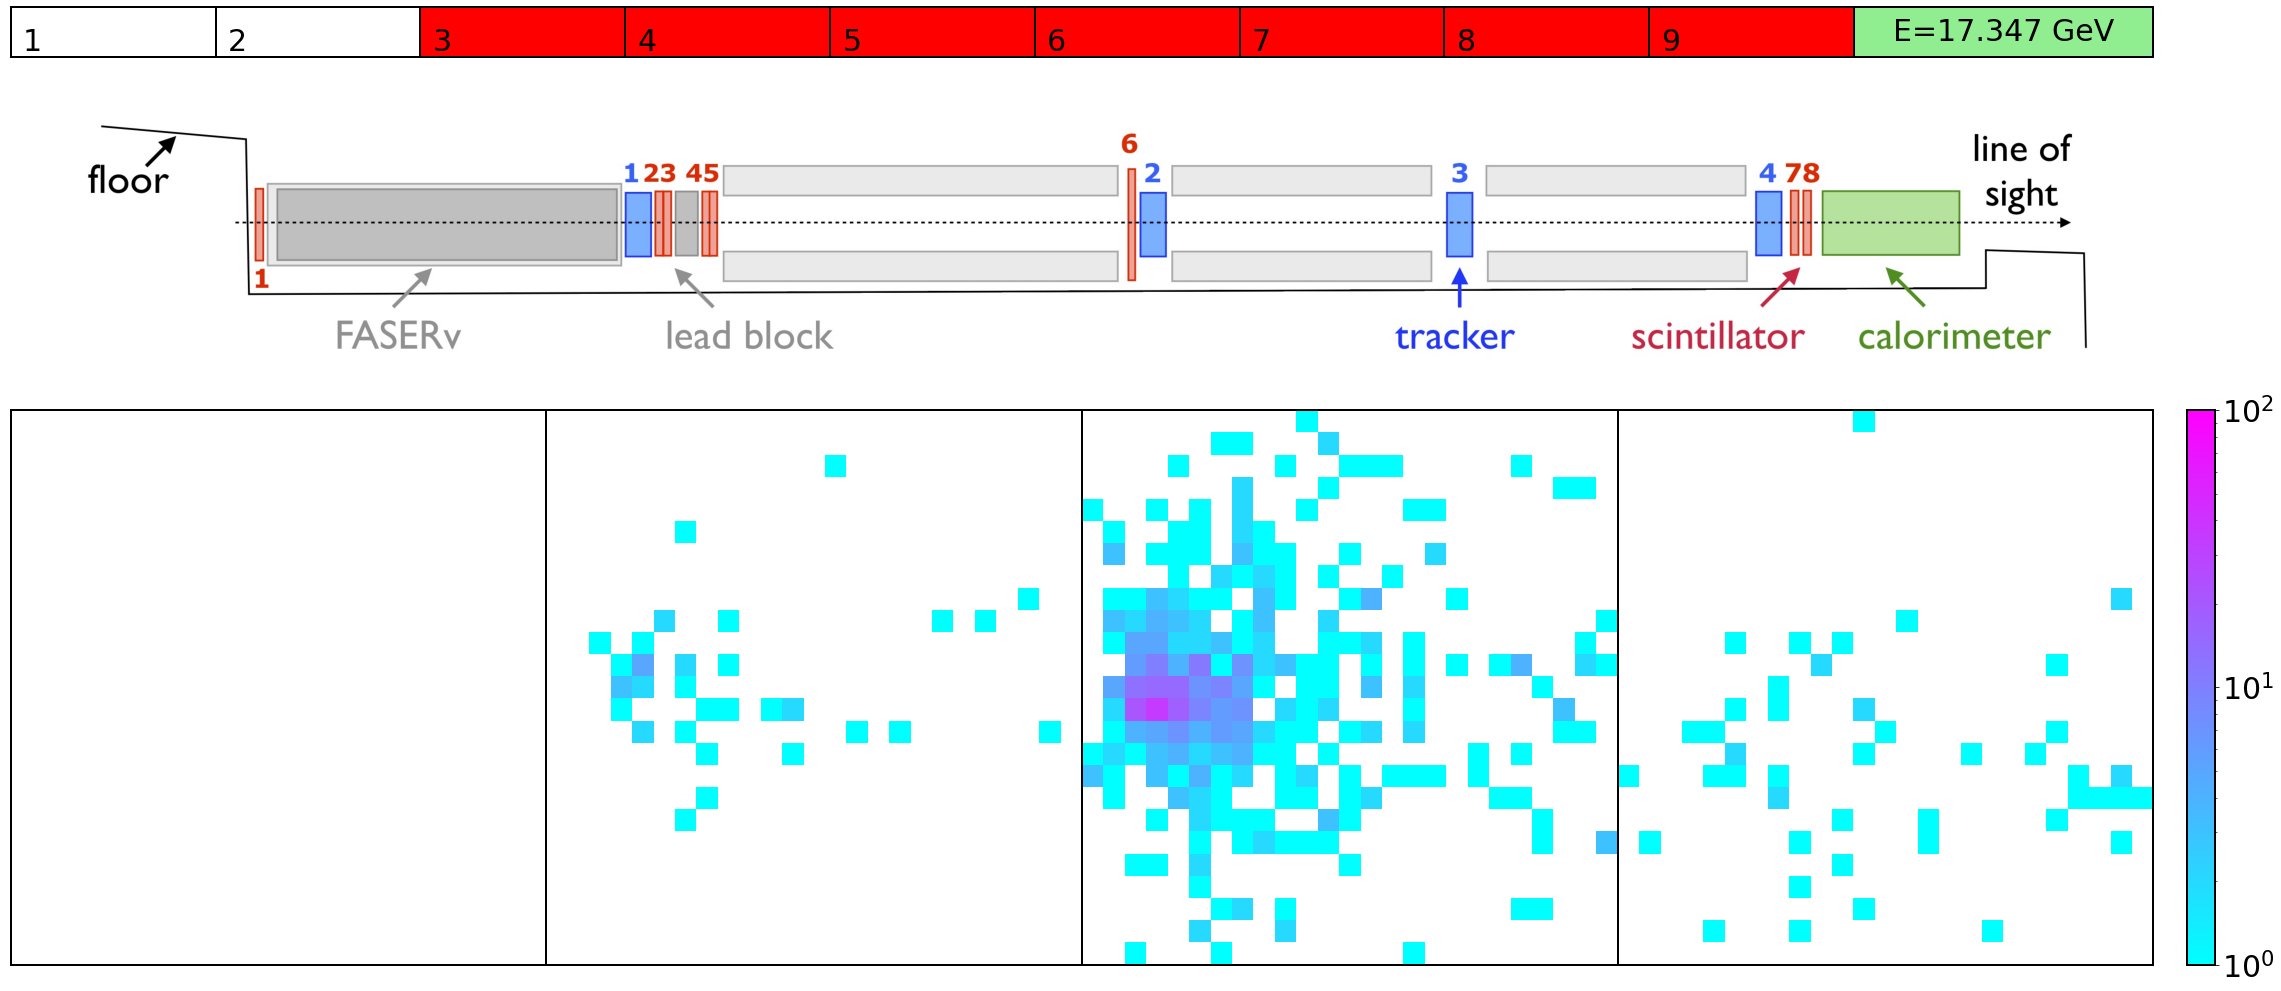

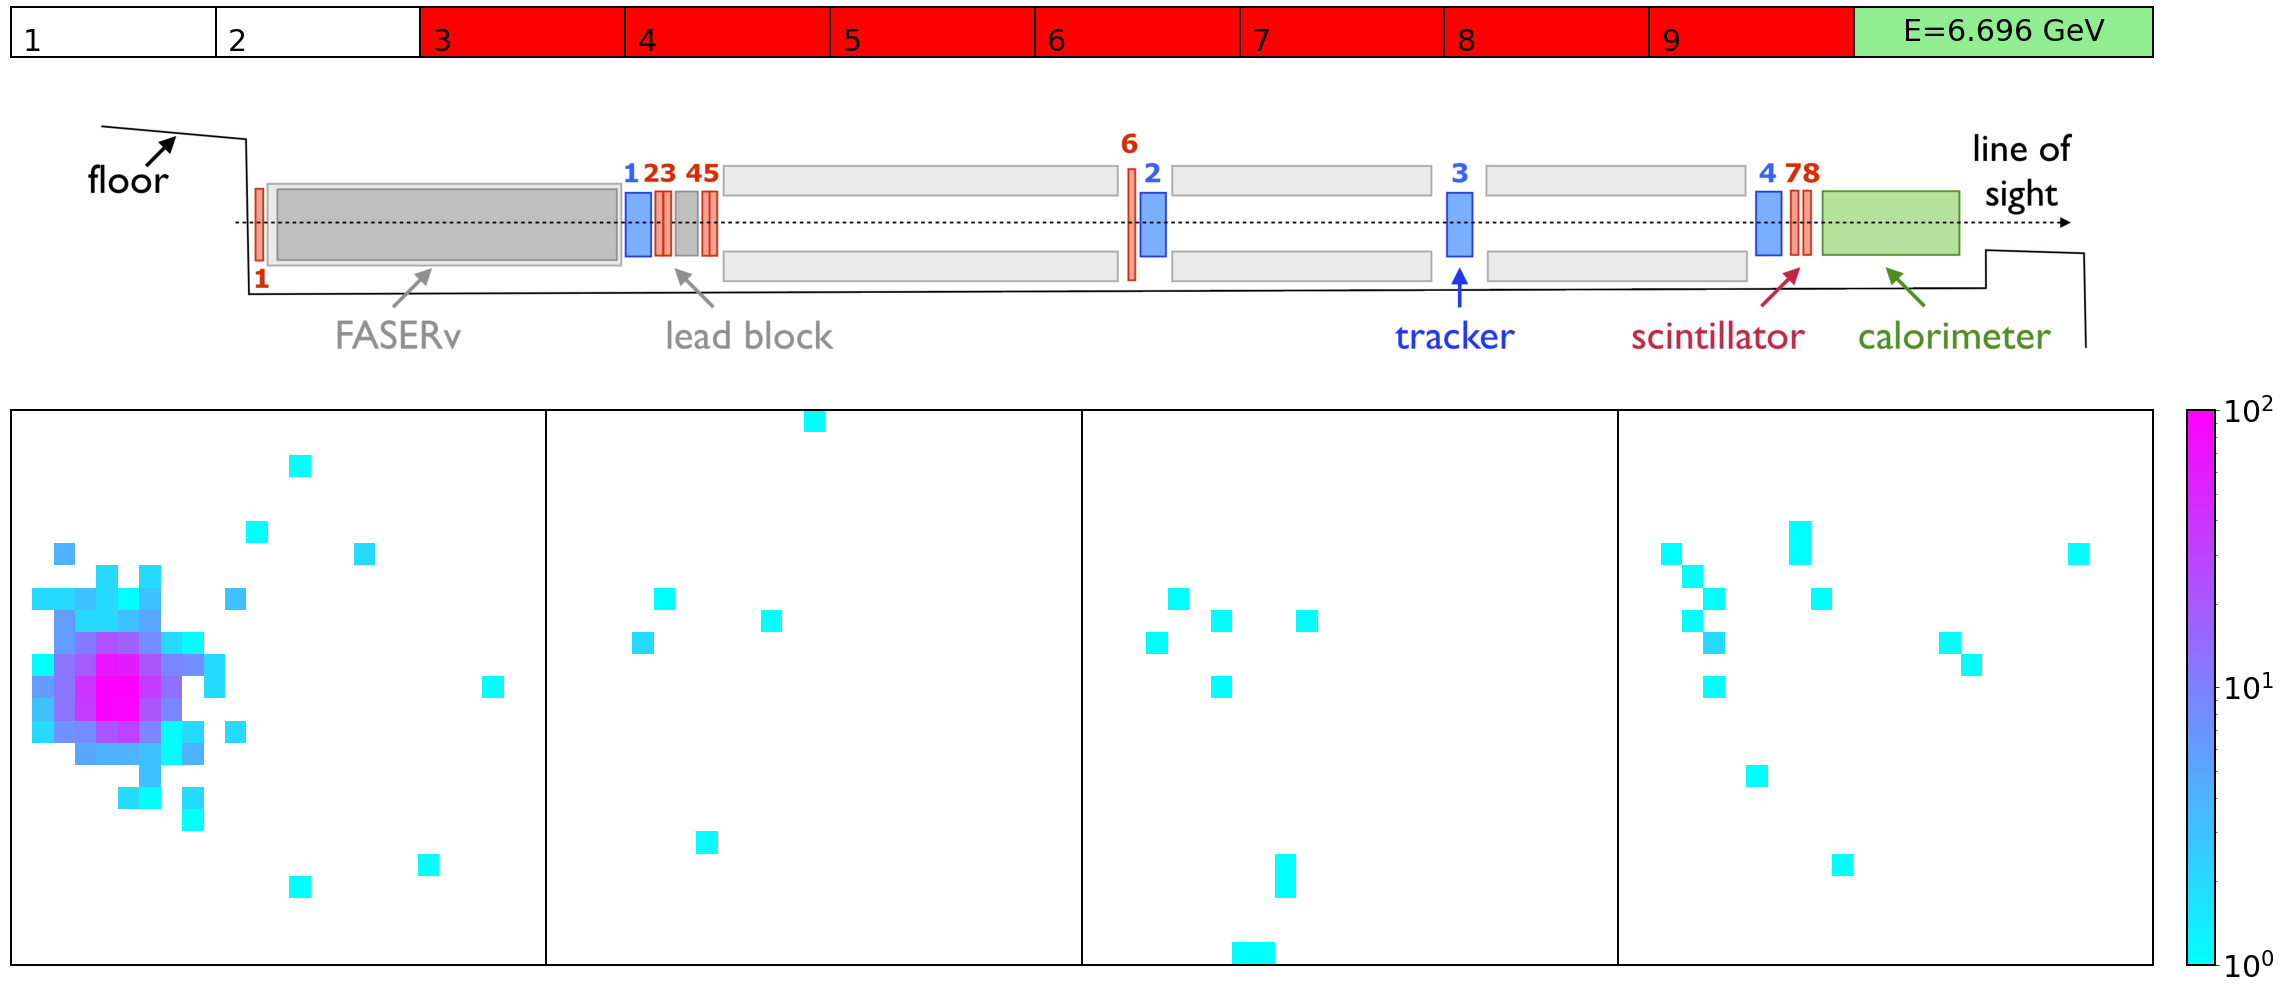

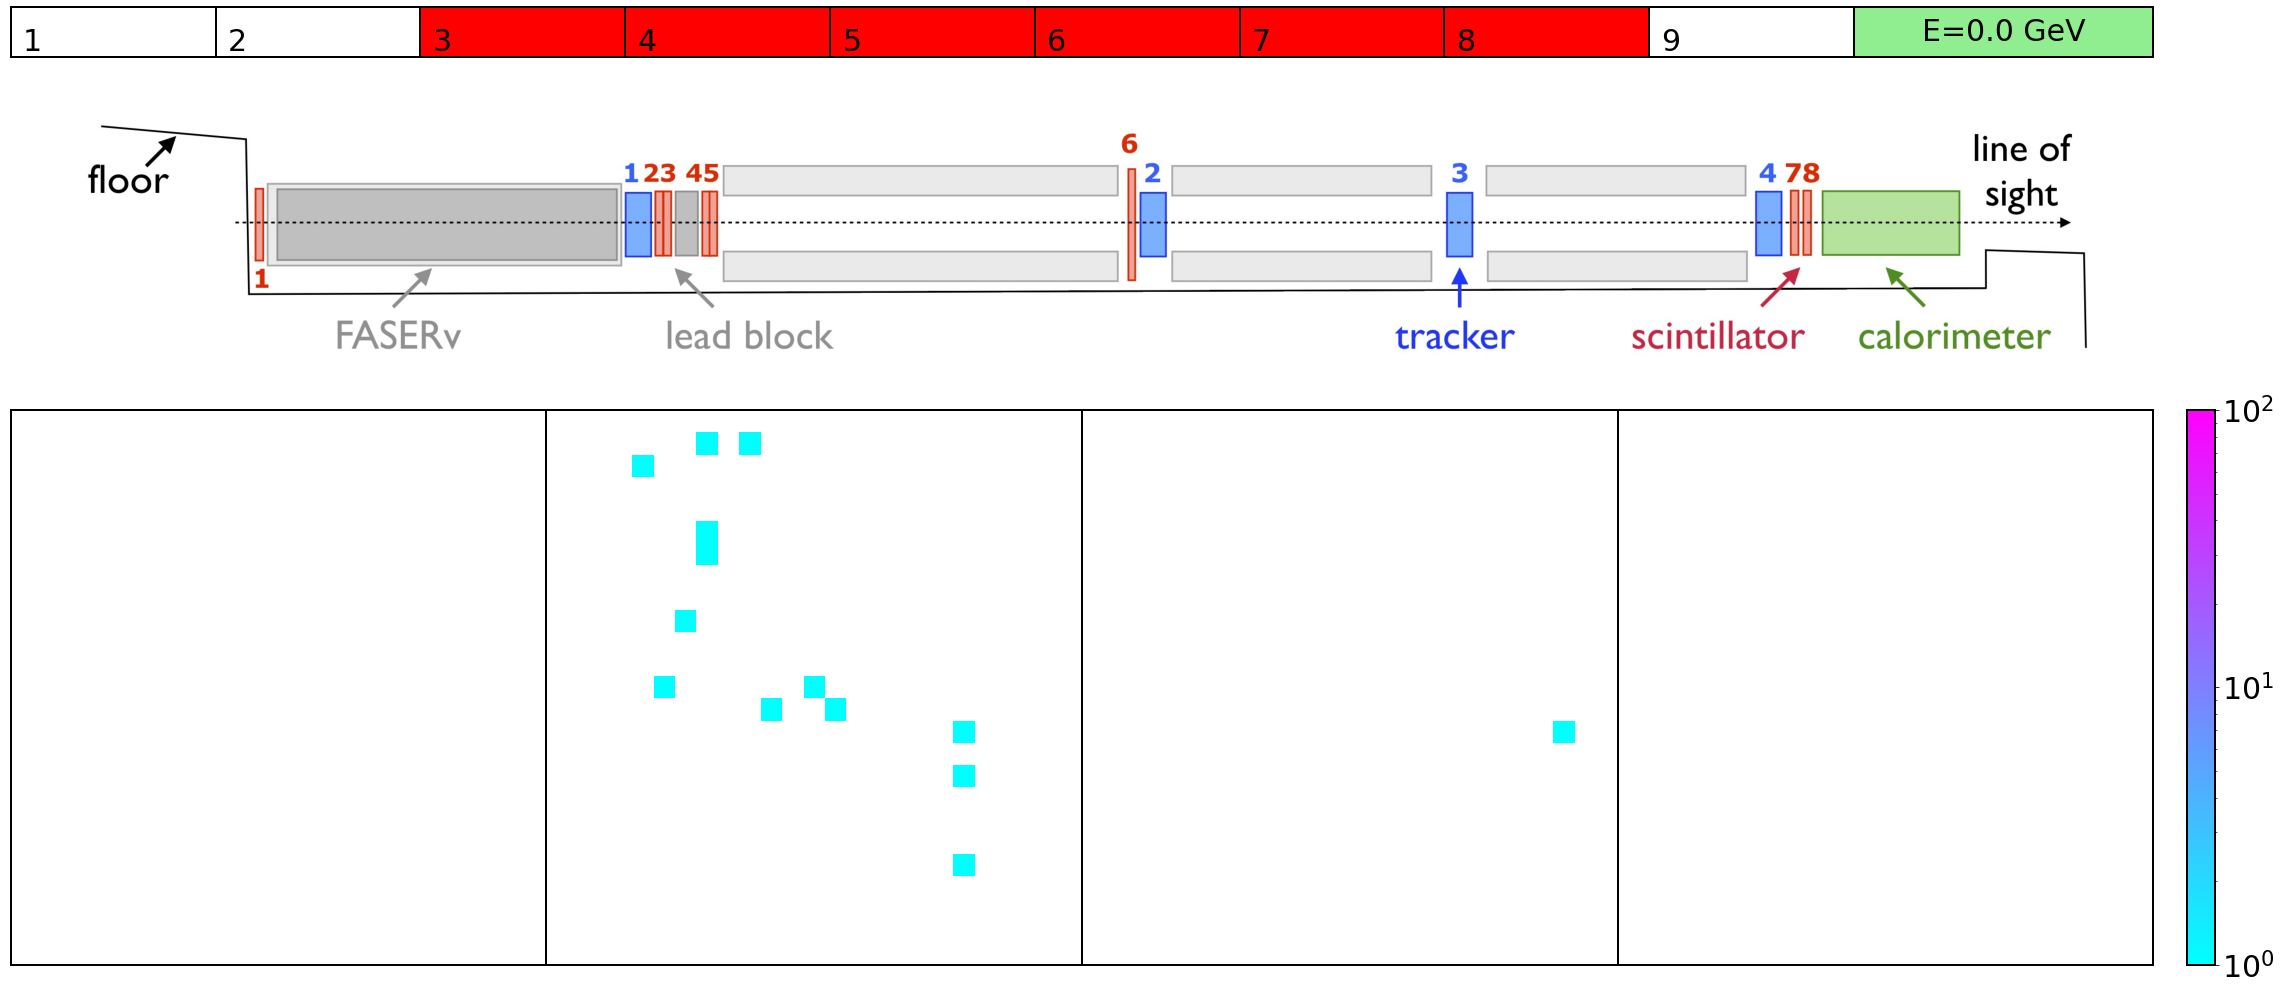

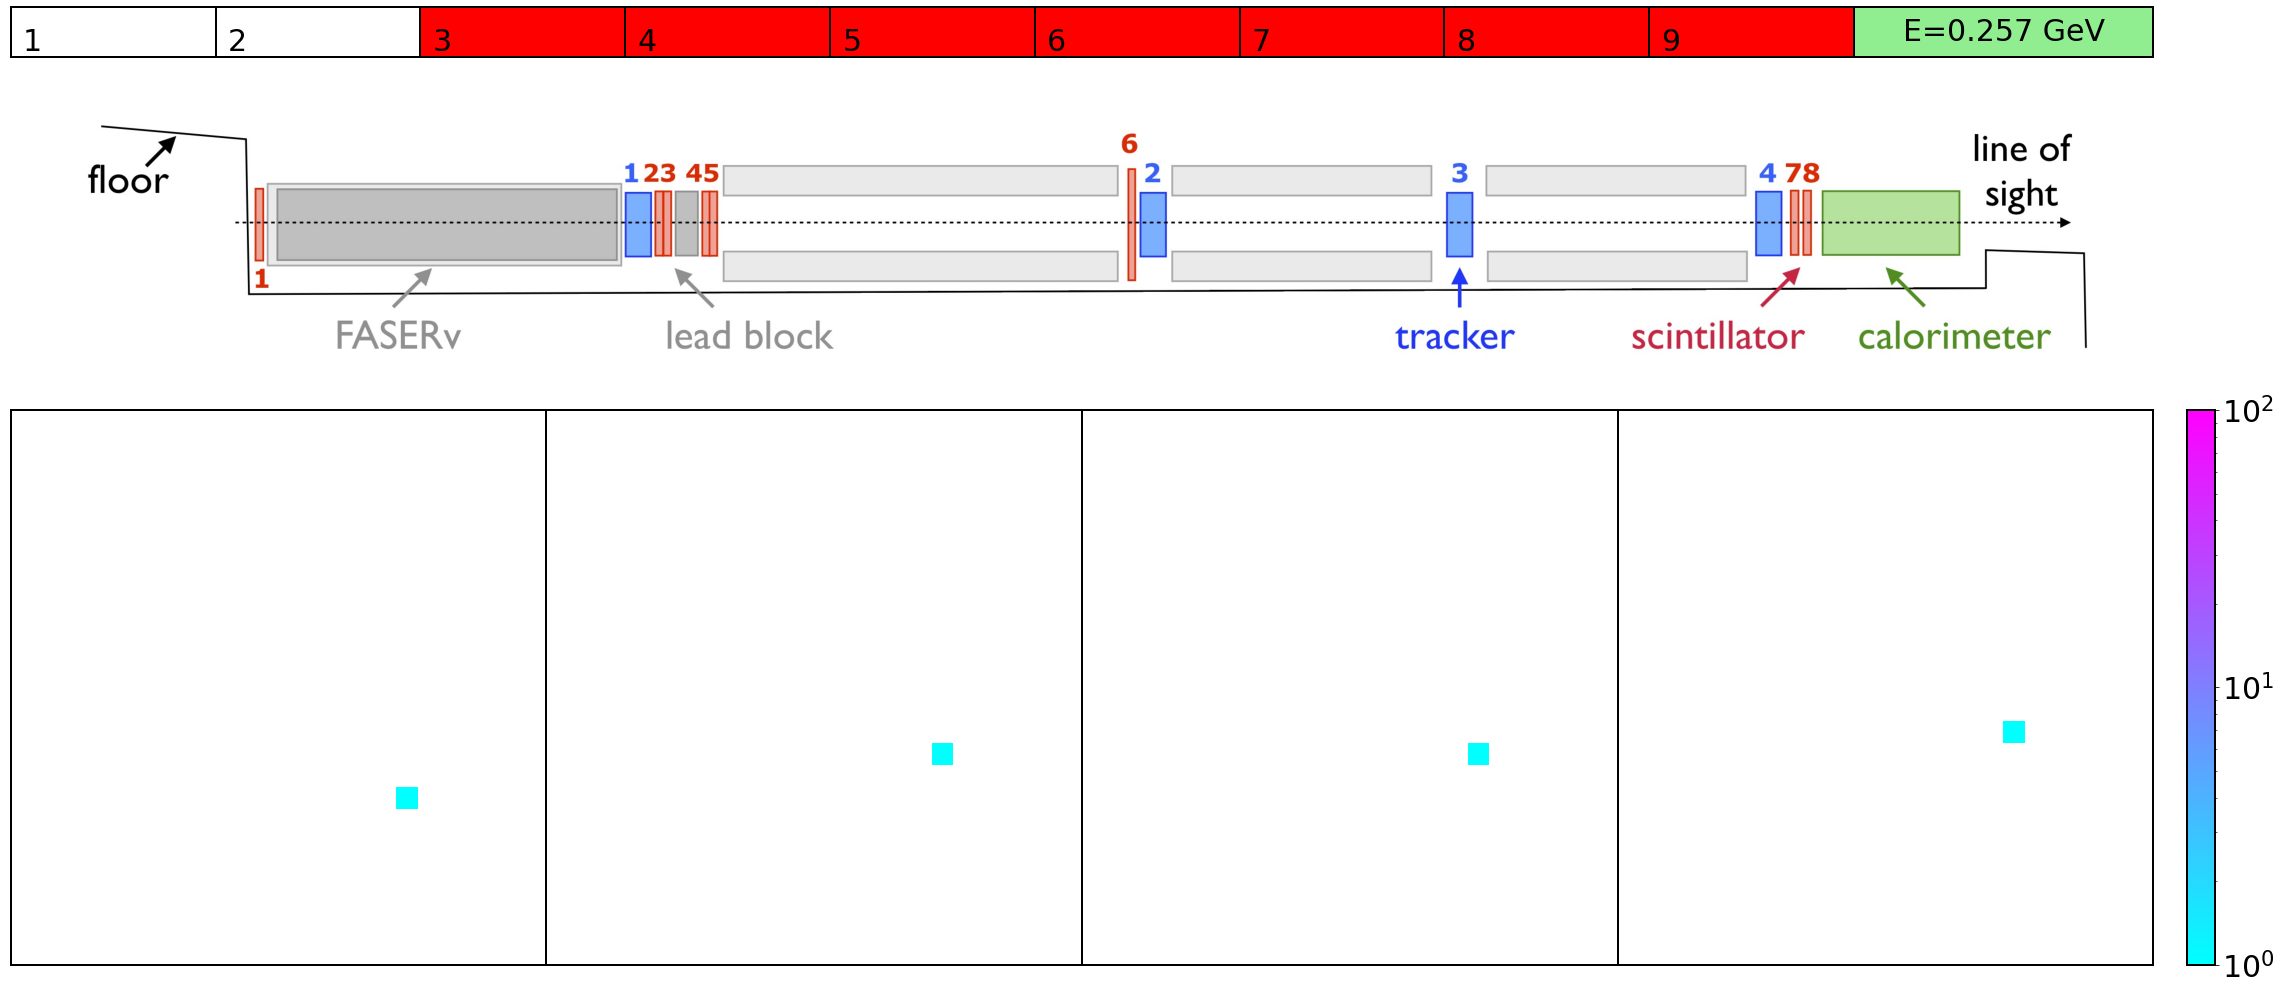

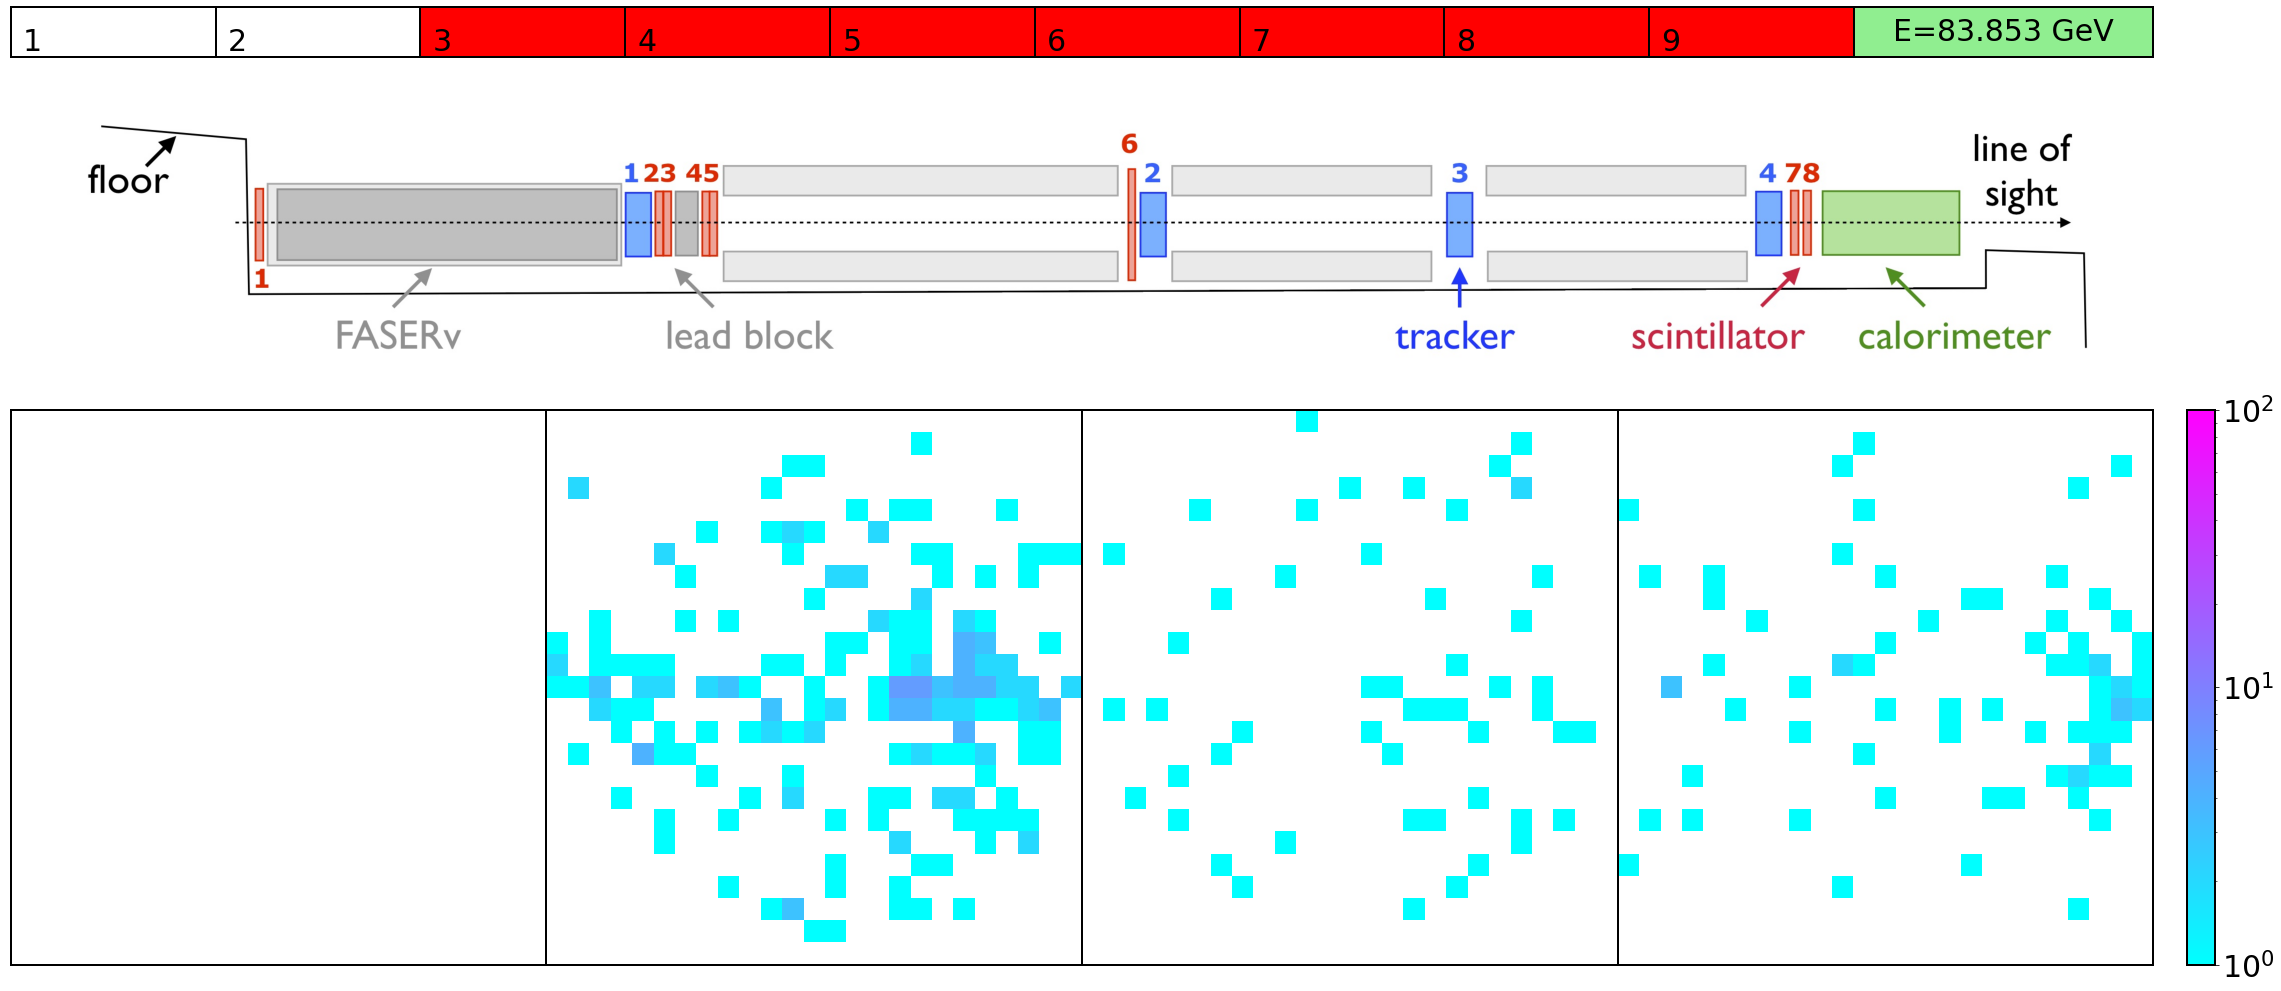

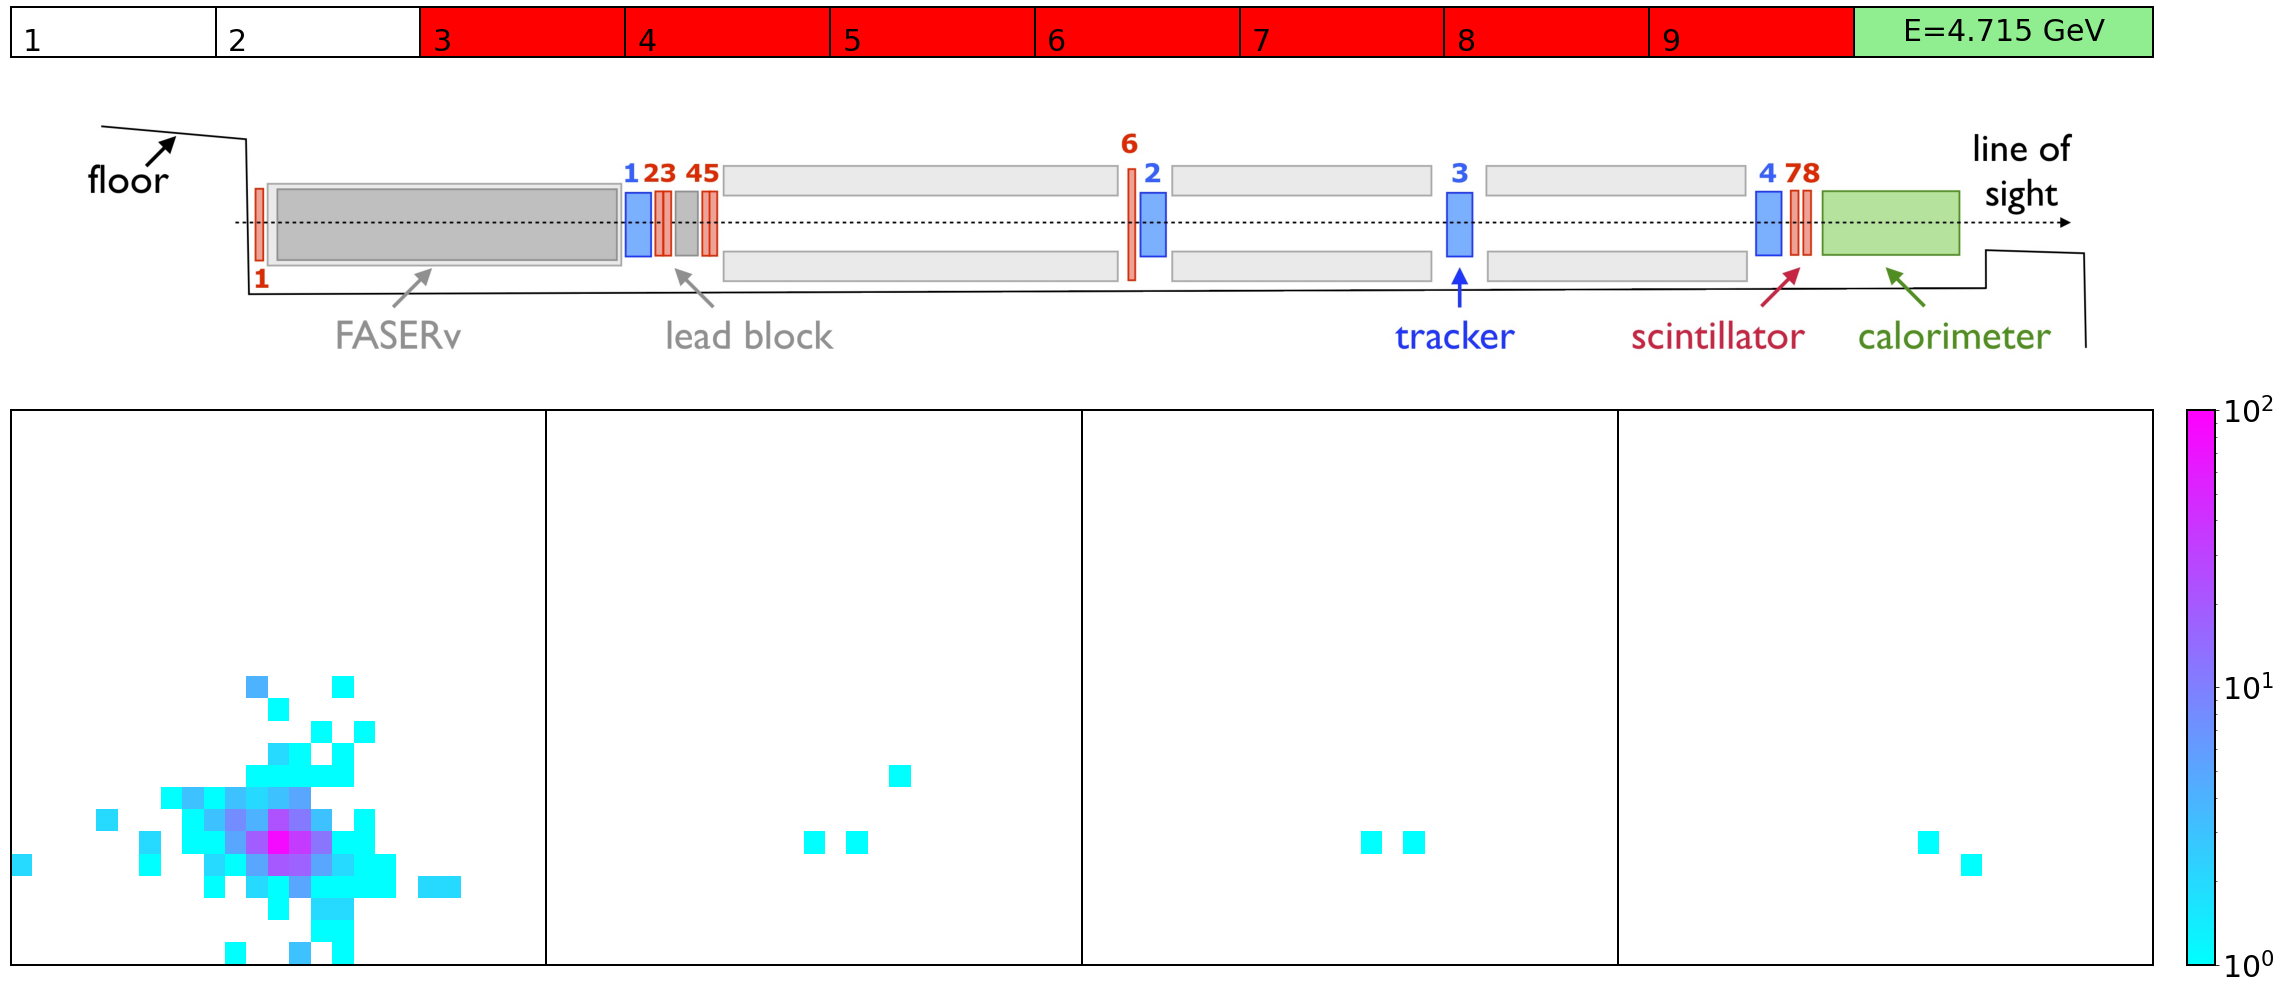

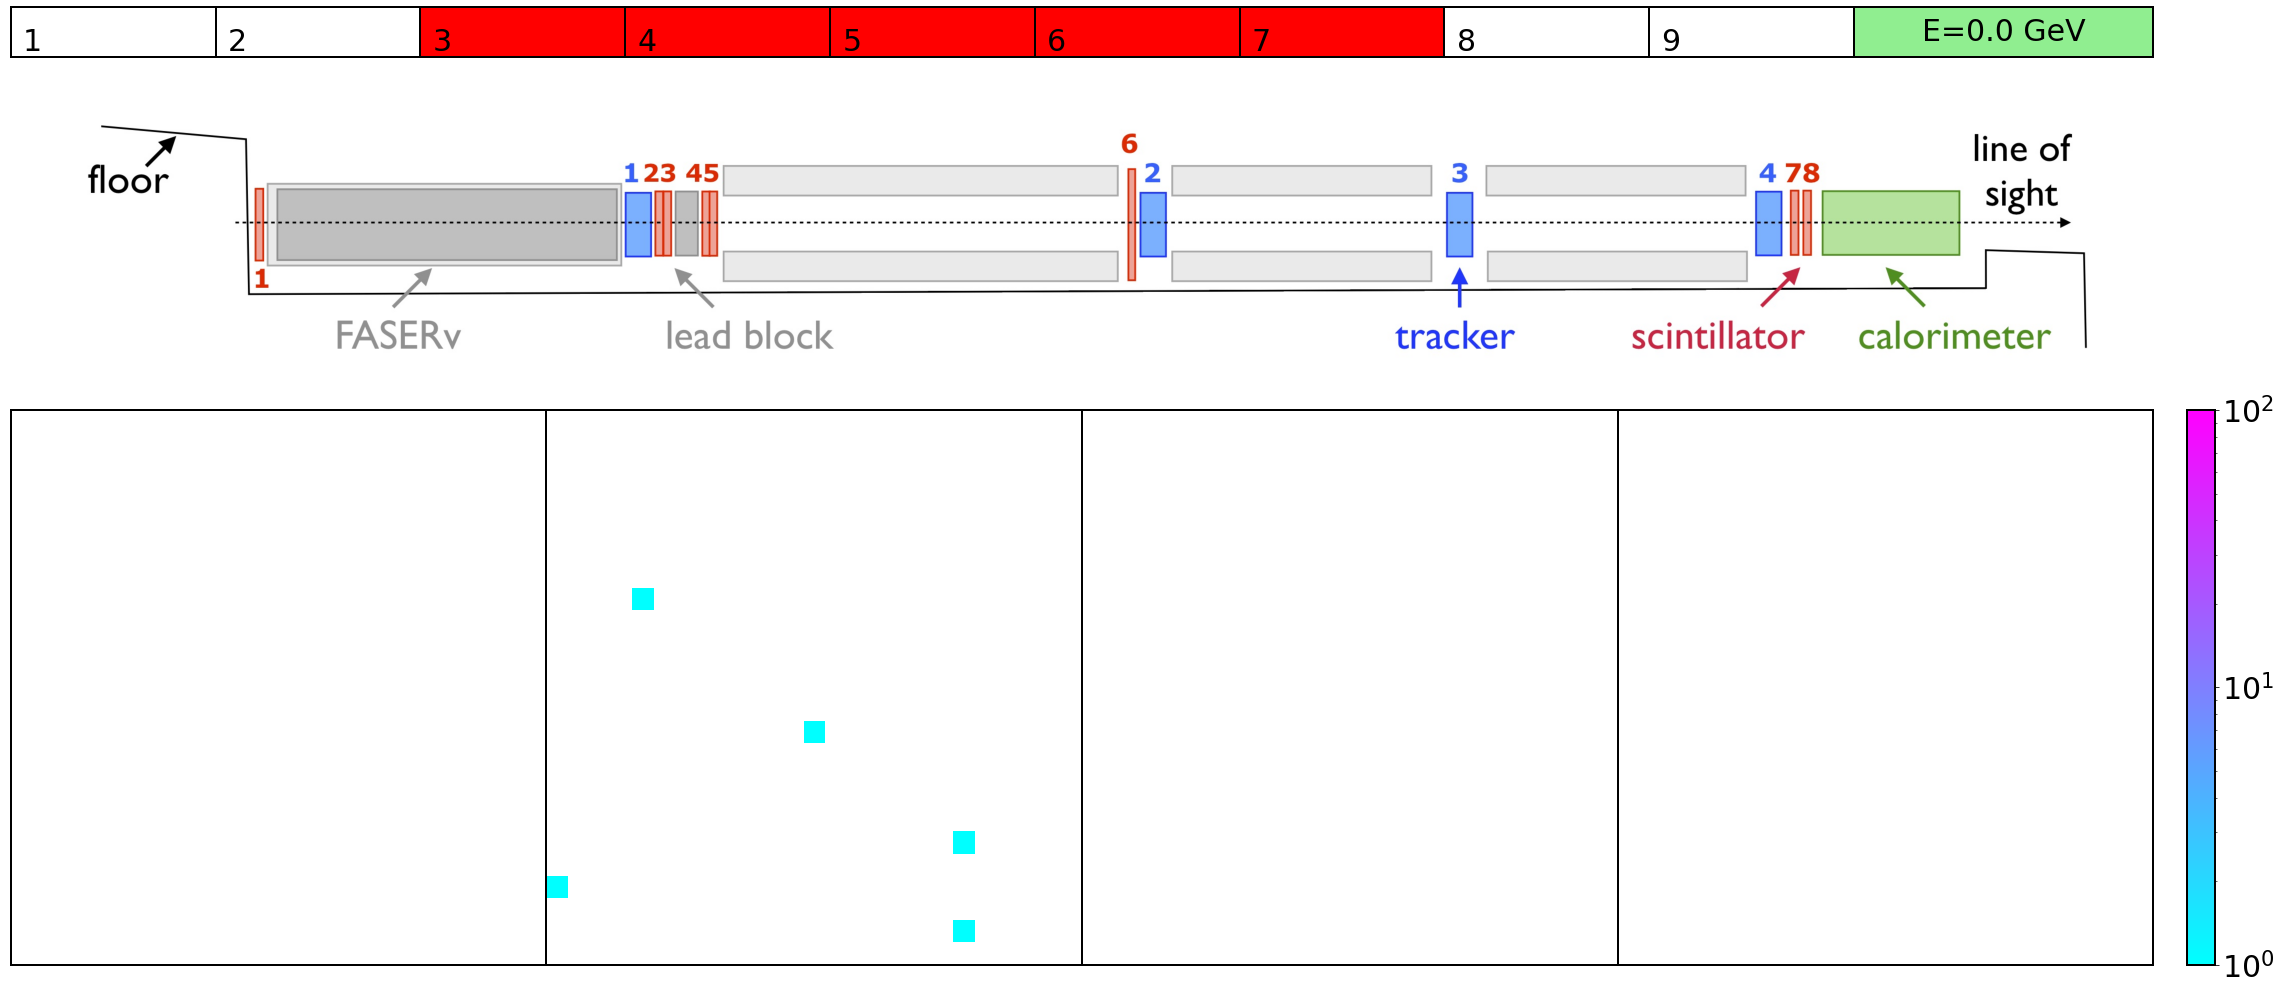

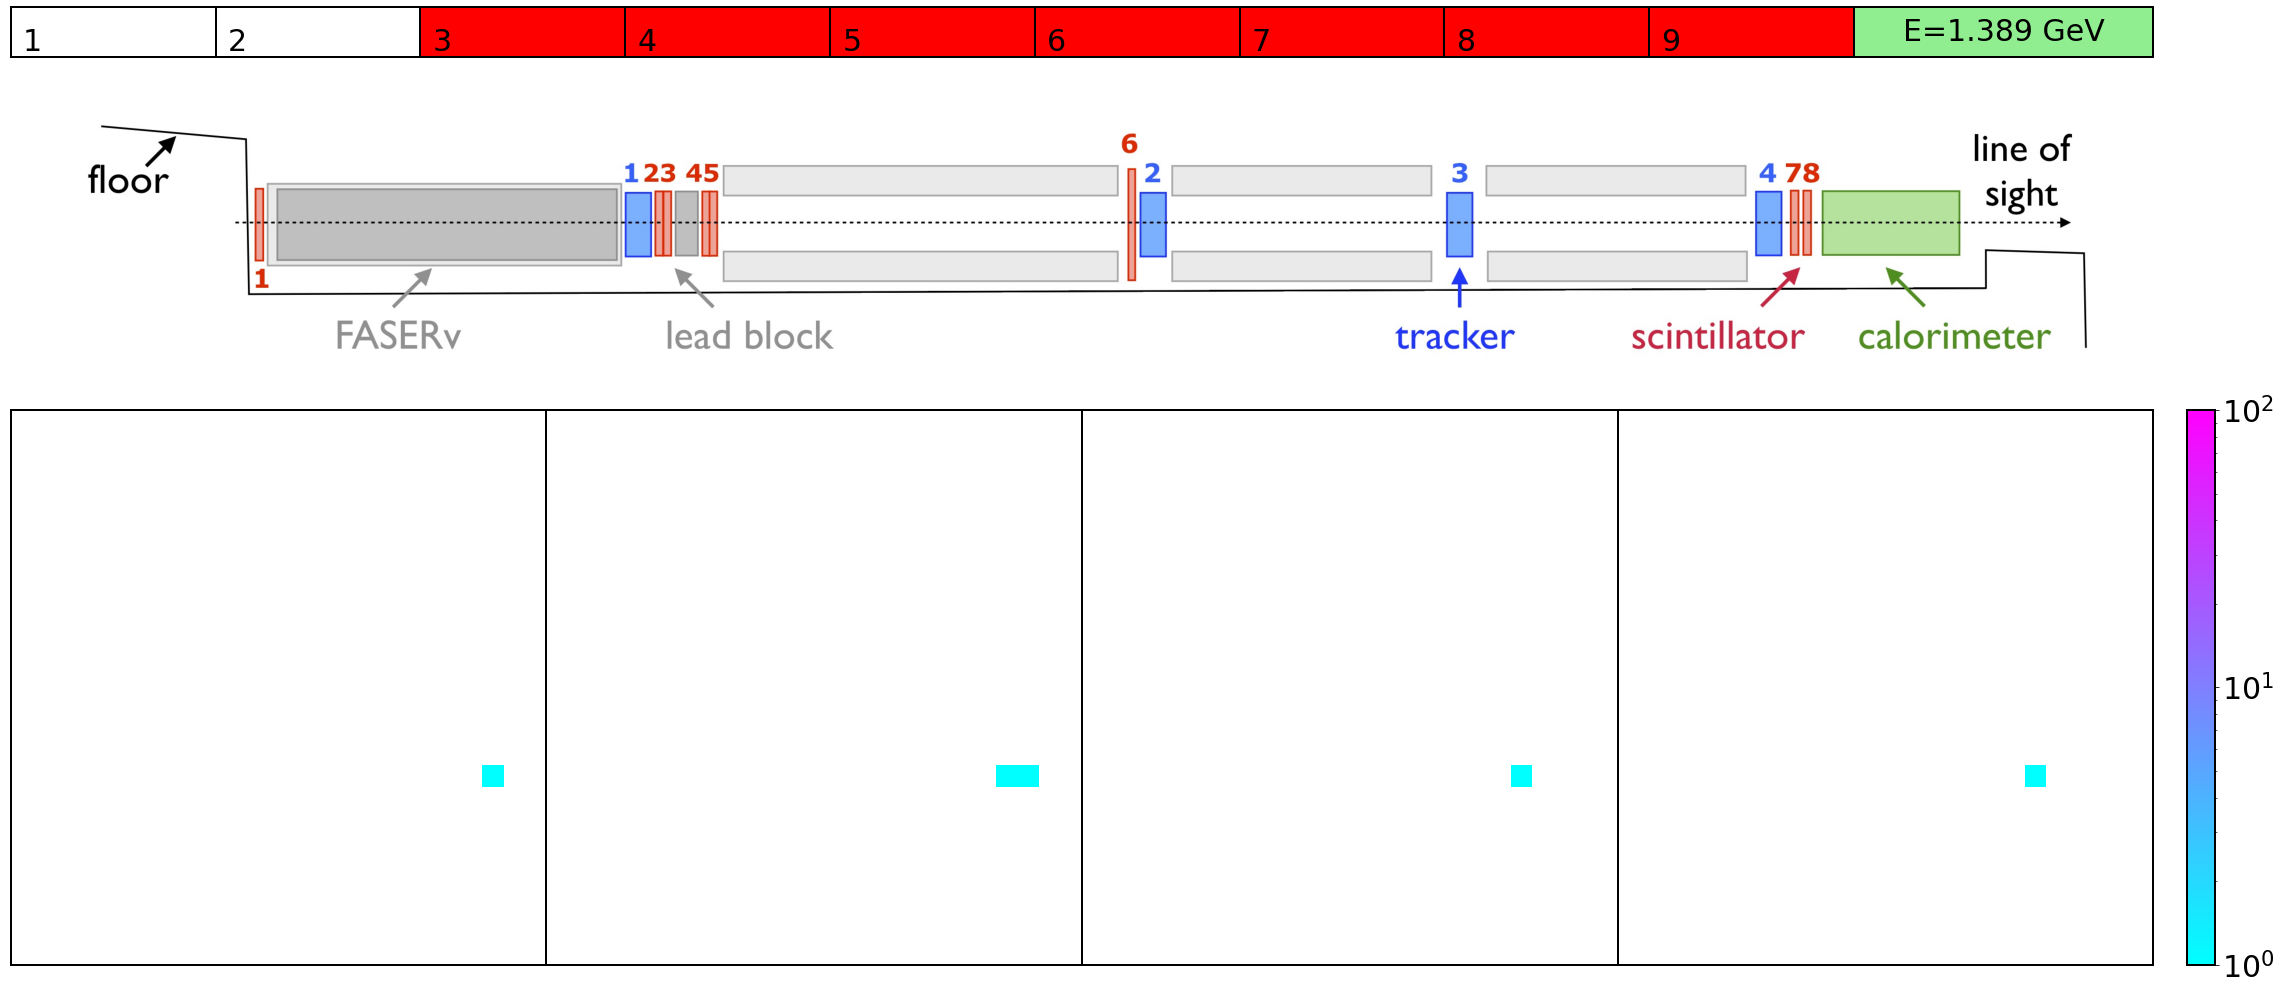

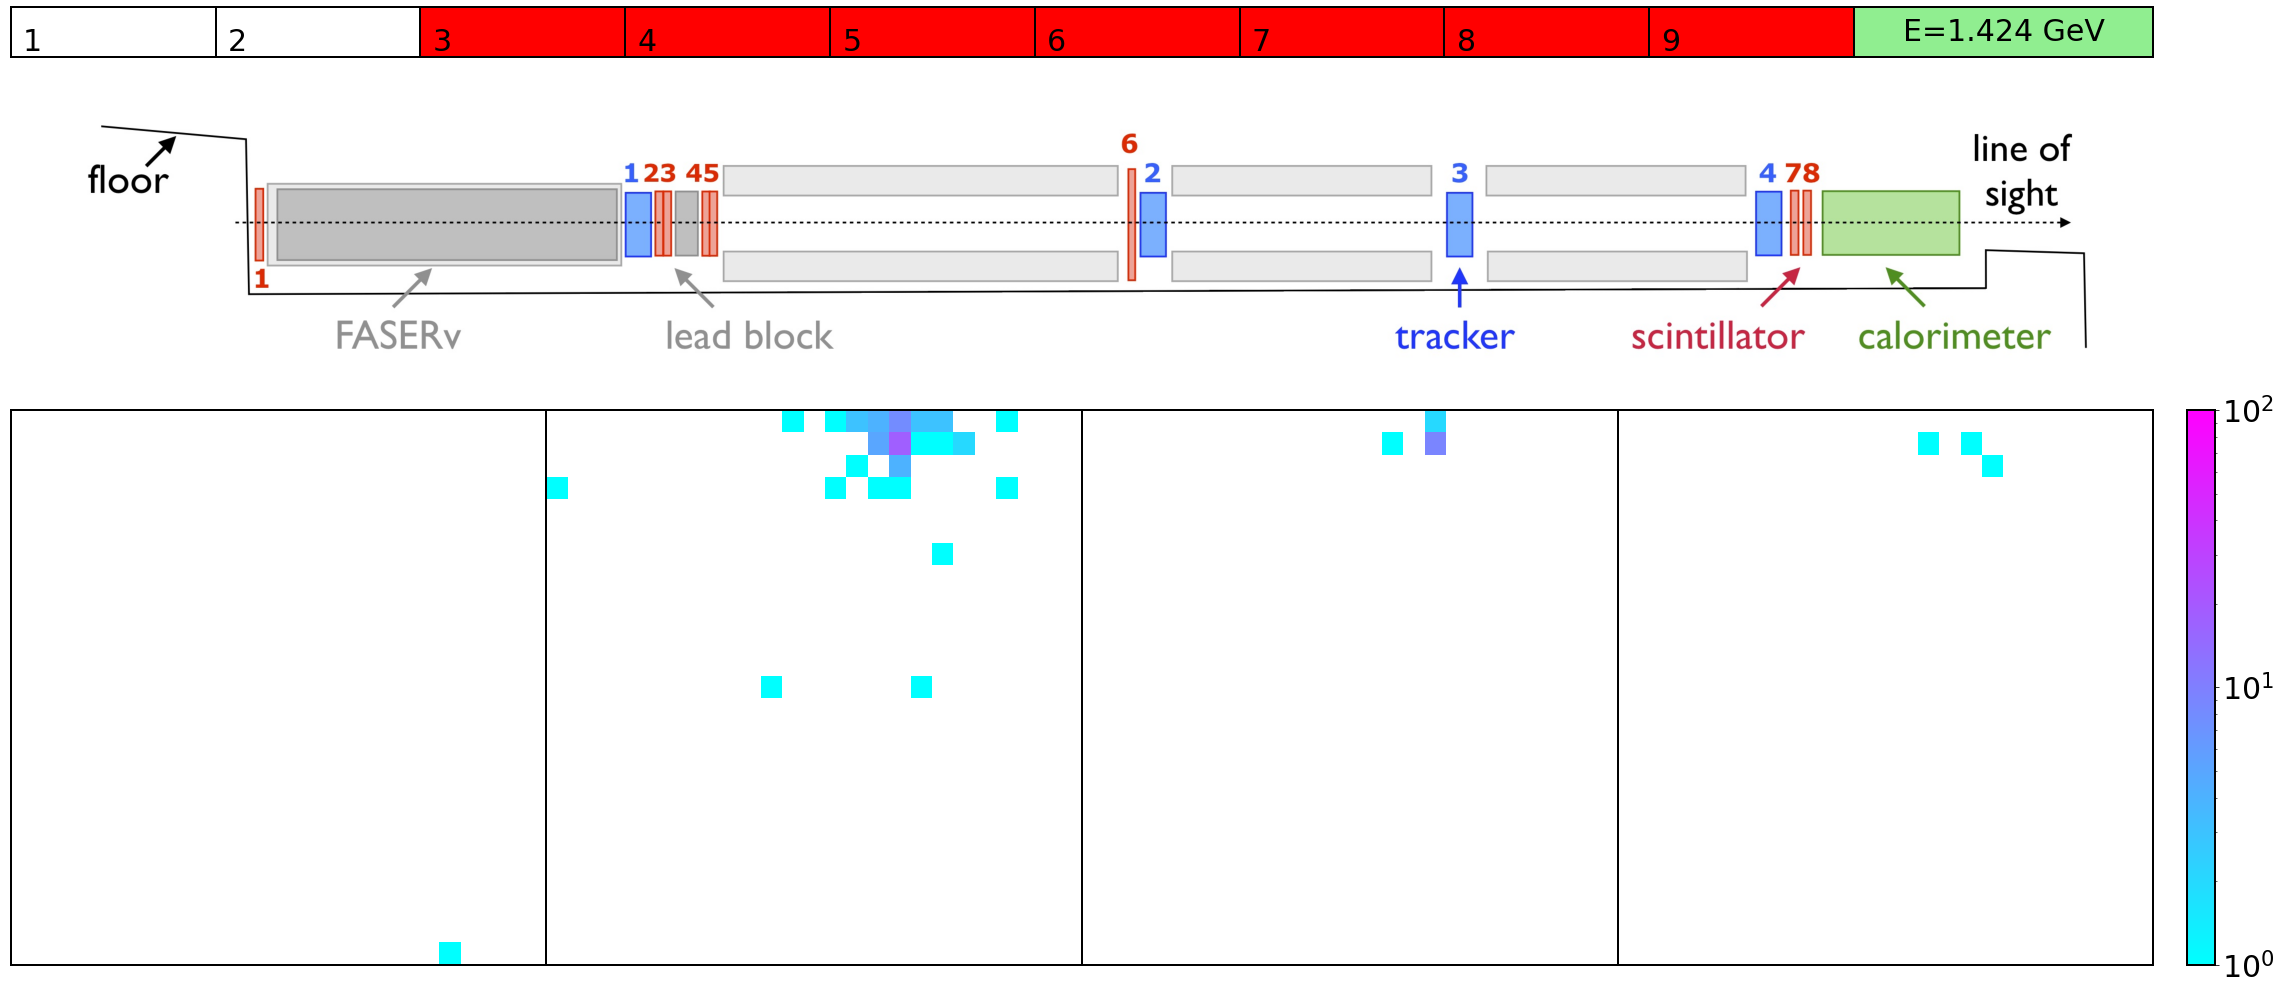

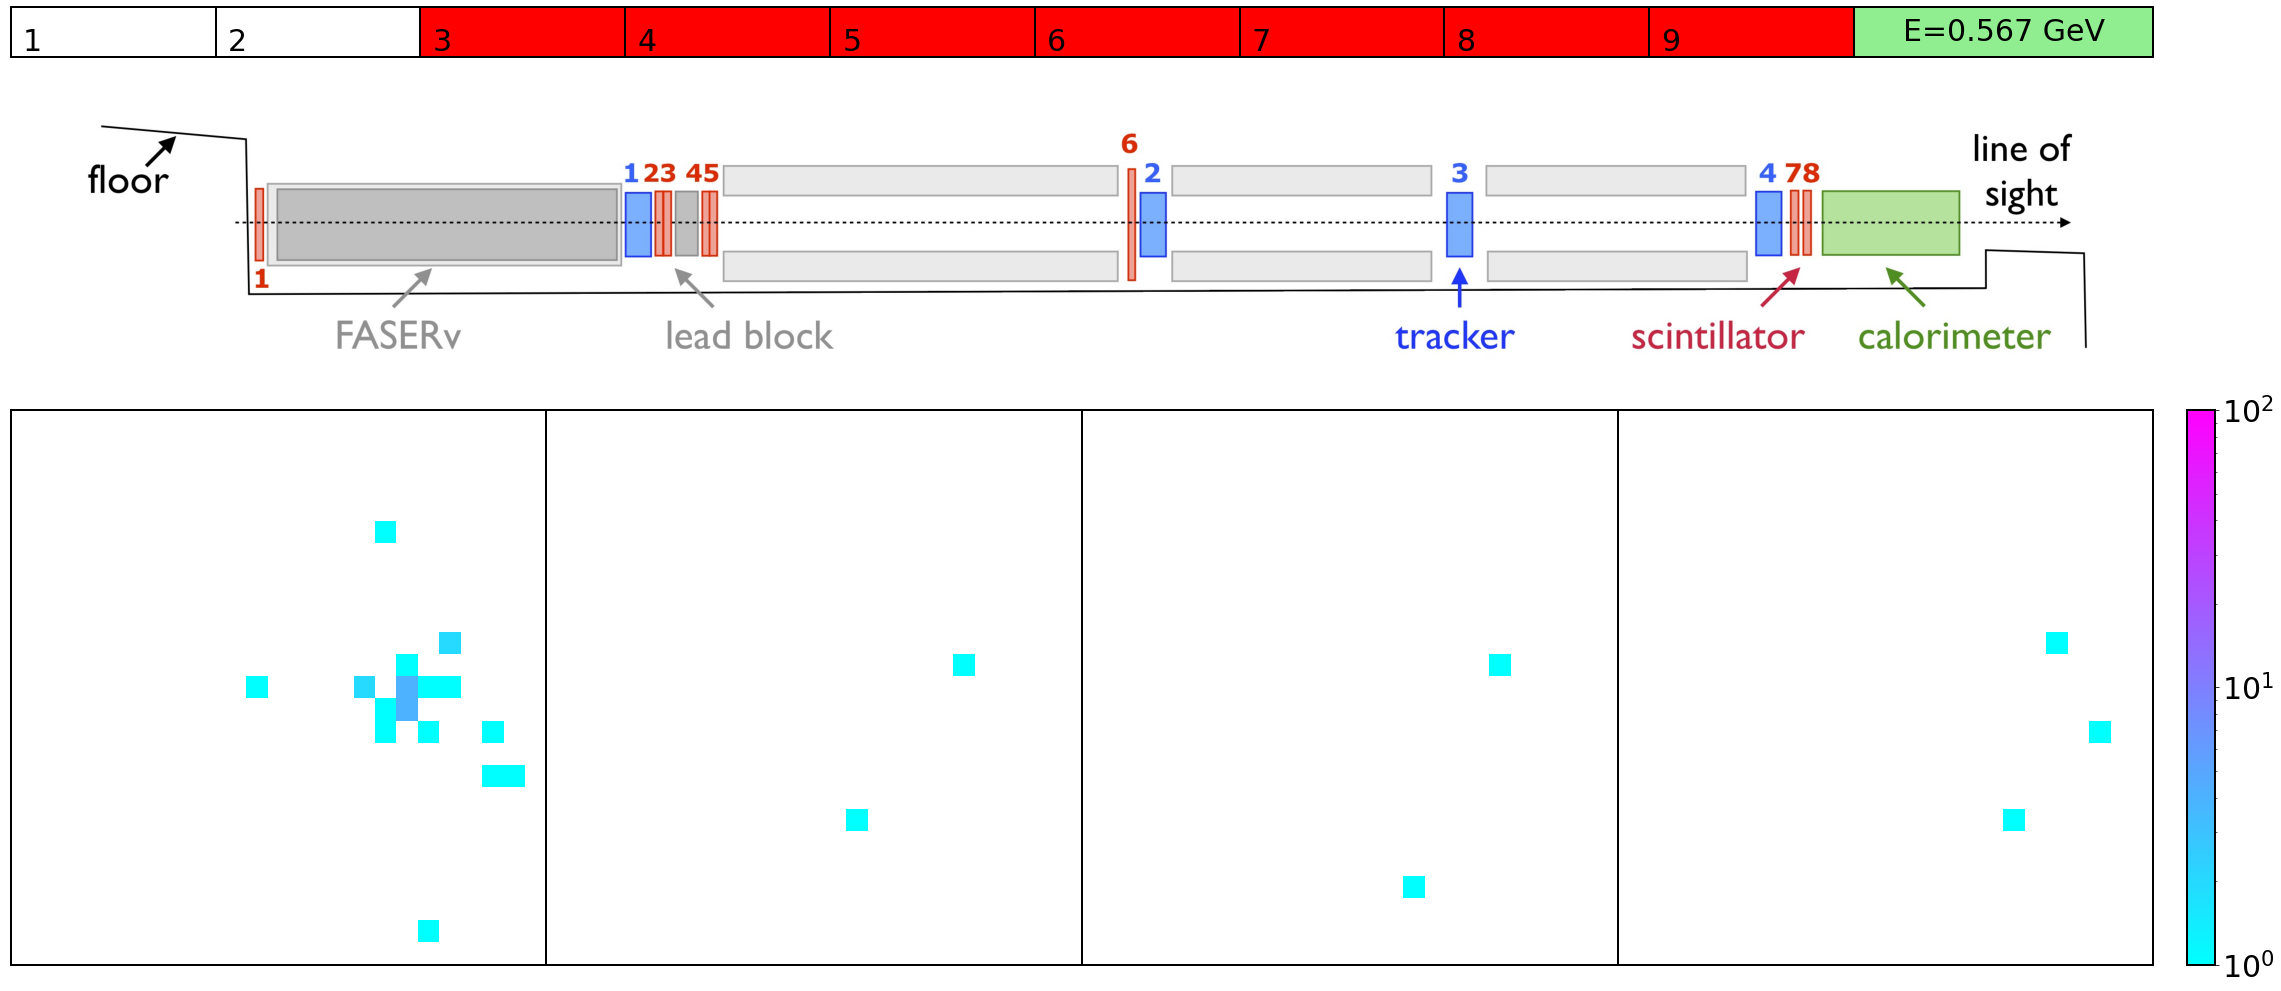

In [7]:
numevents = 0 
while numevents < 10:
    ievent = random.randrange(len(neutrino_data))
    numevents+=display_event(neutrino_data, ievent=ievent)

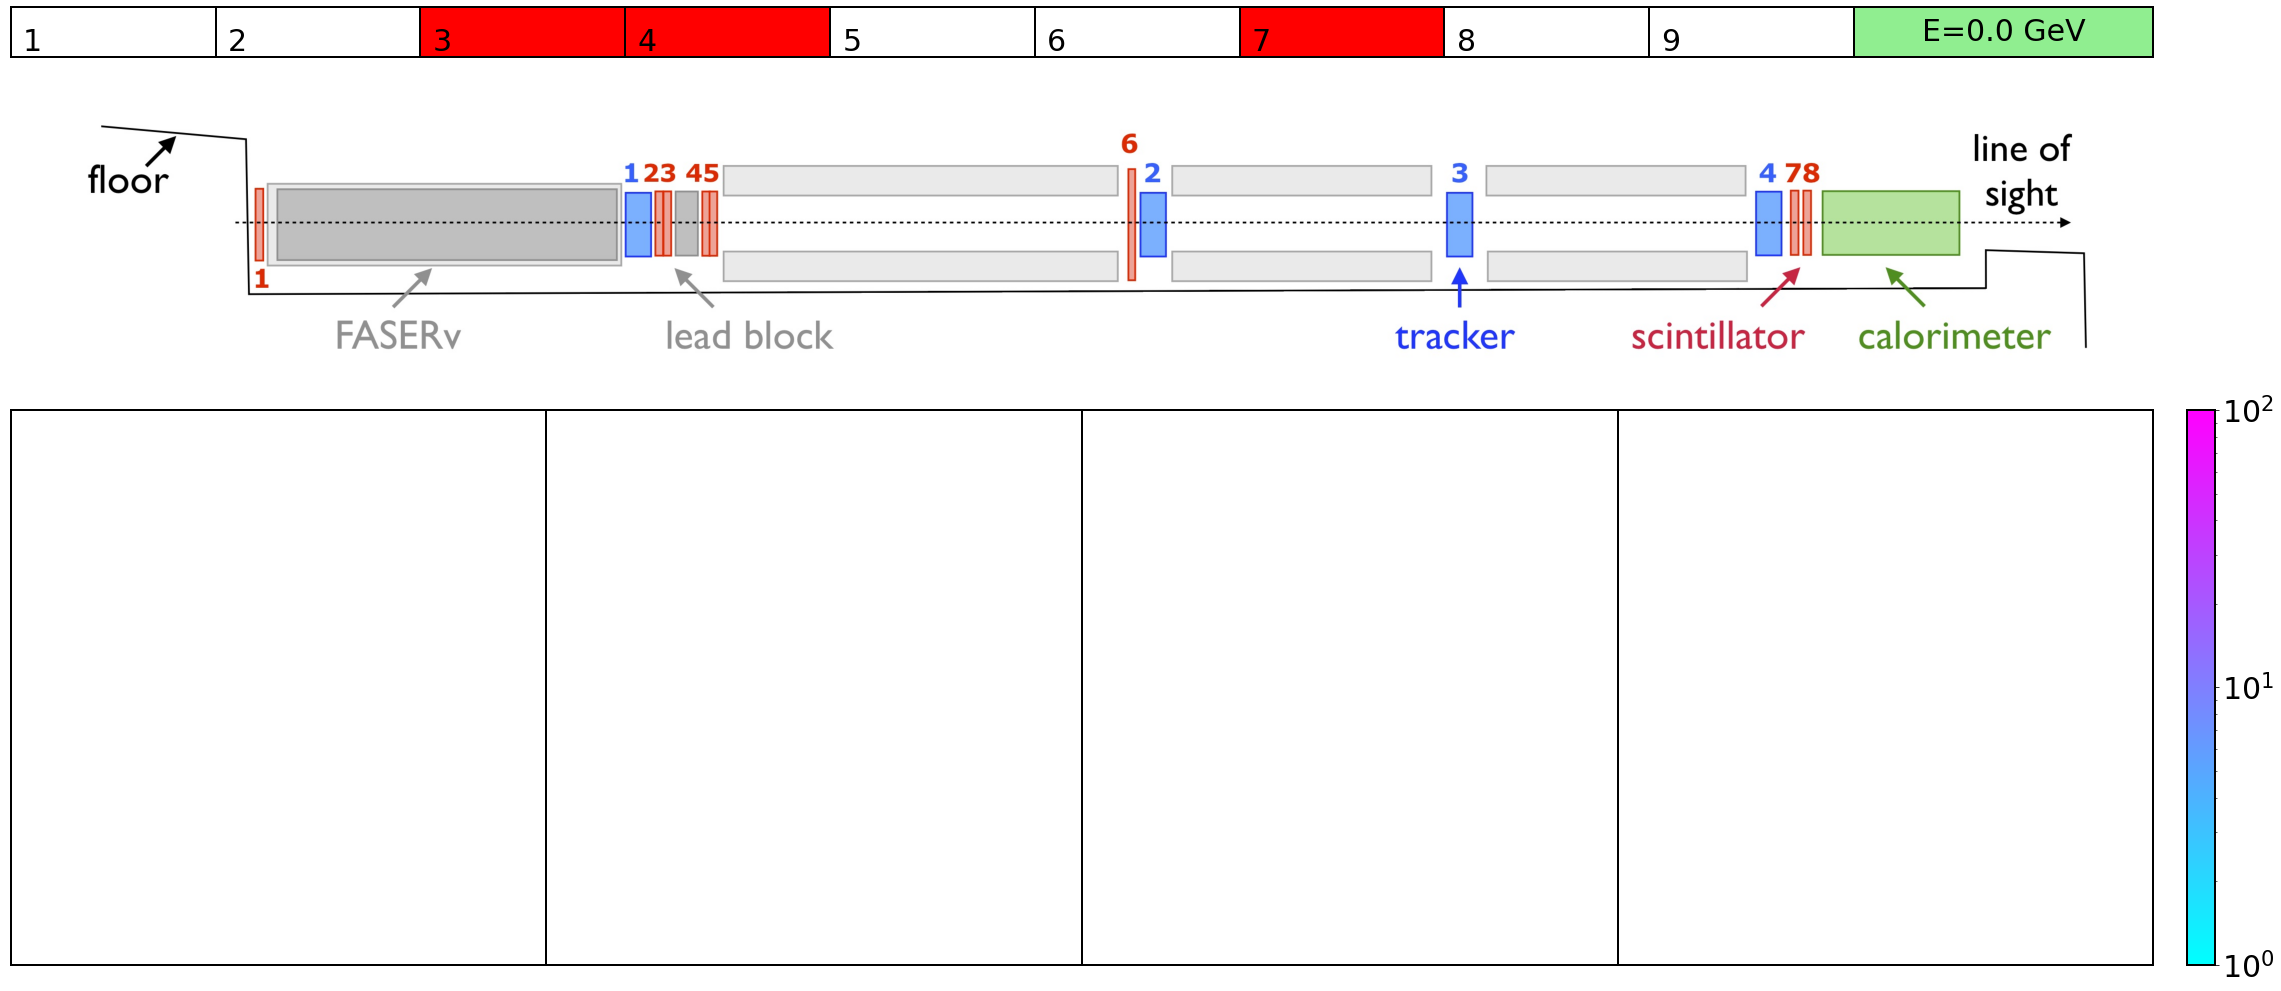

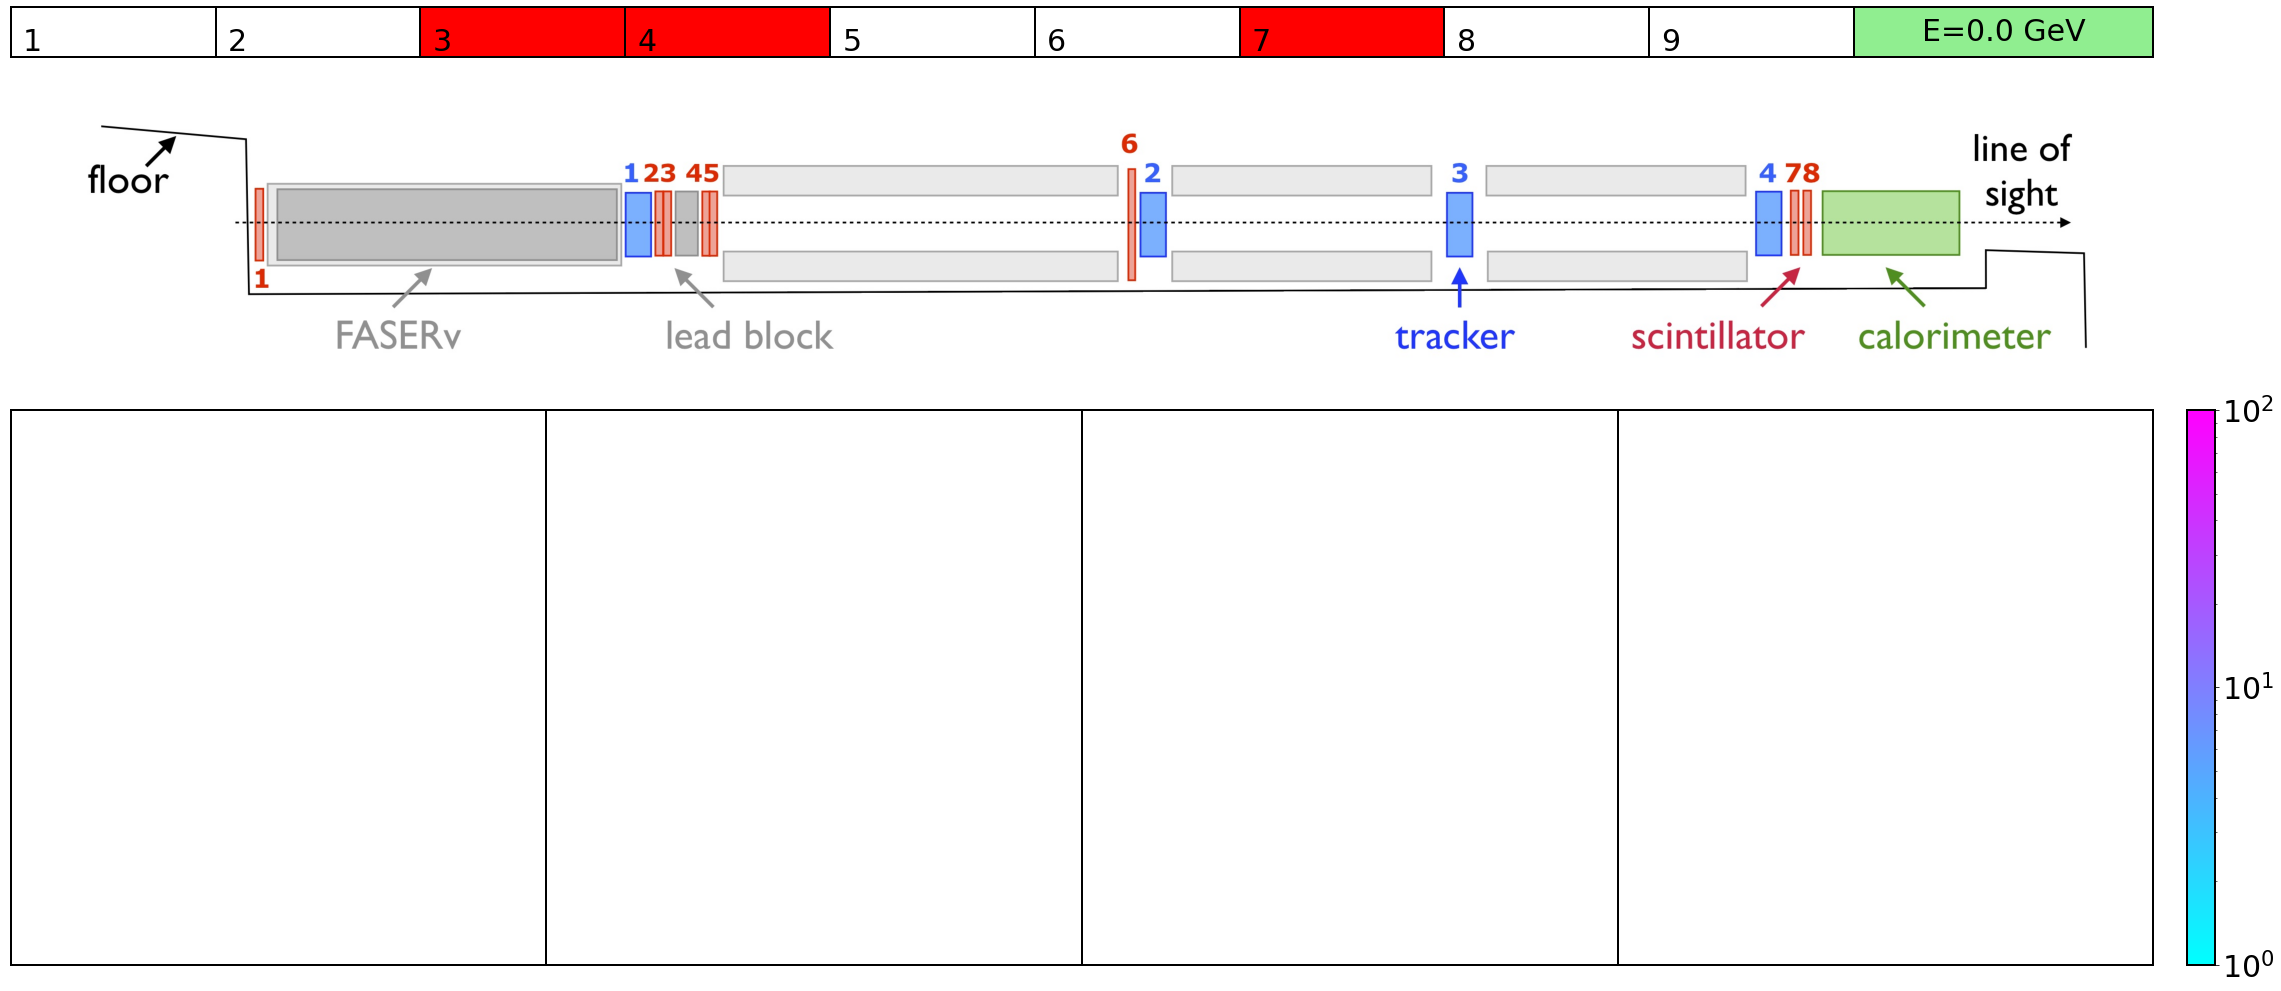

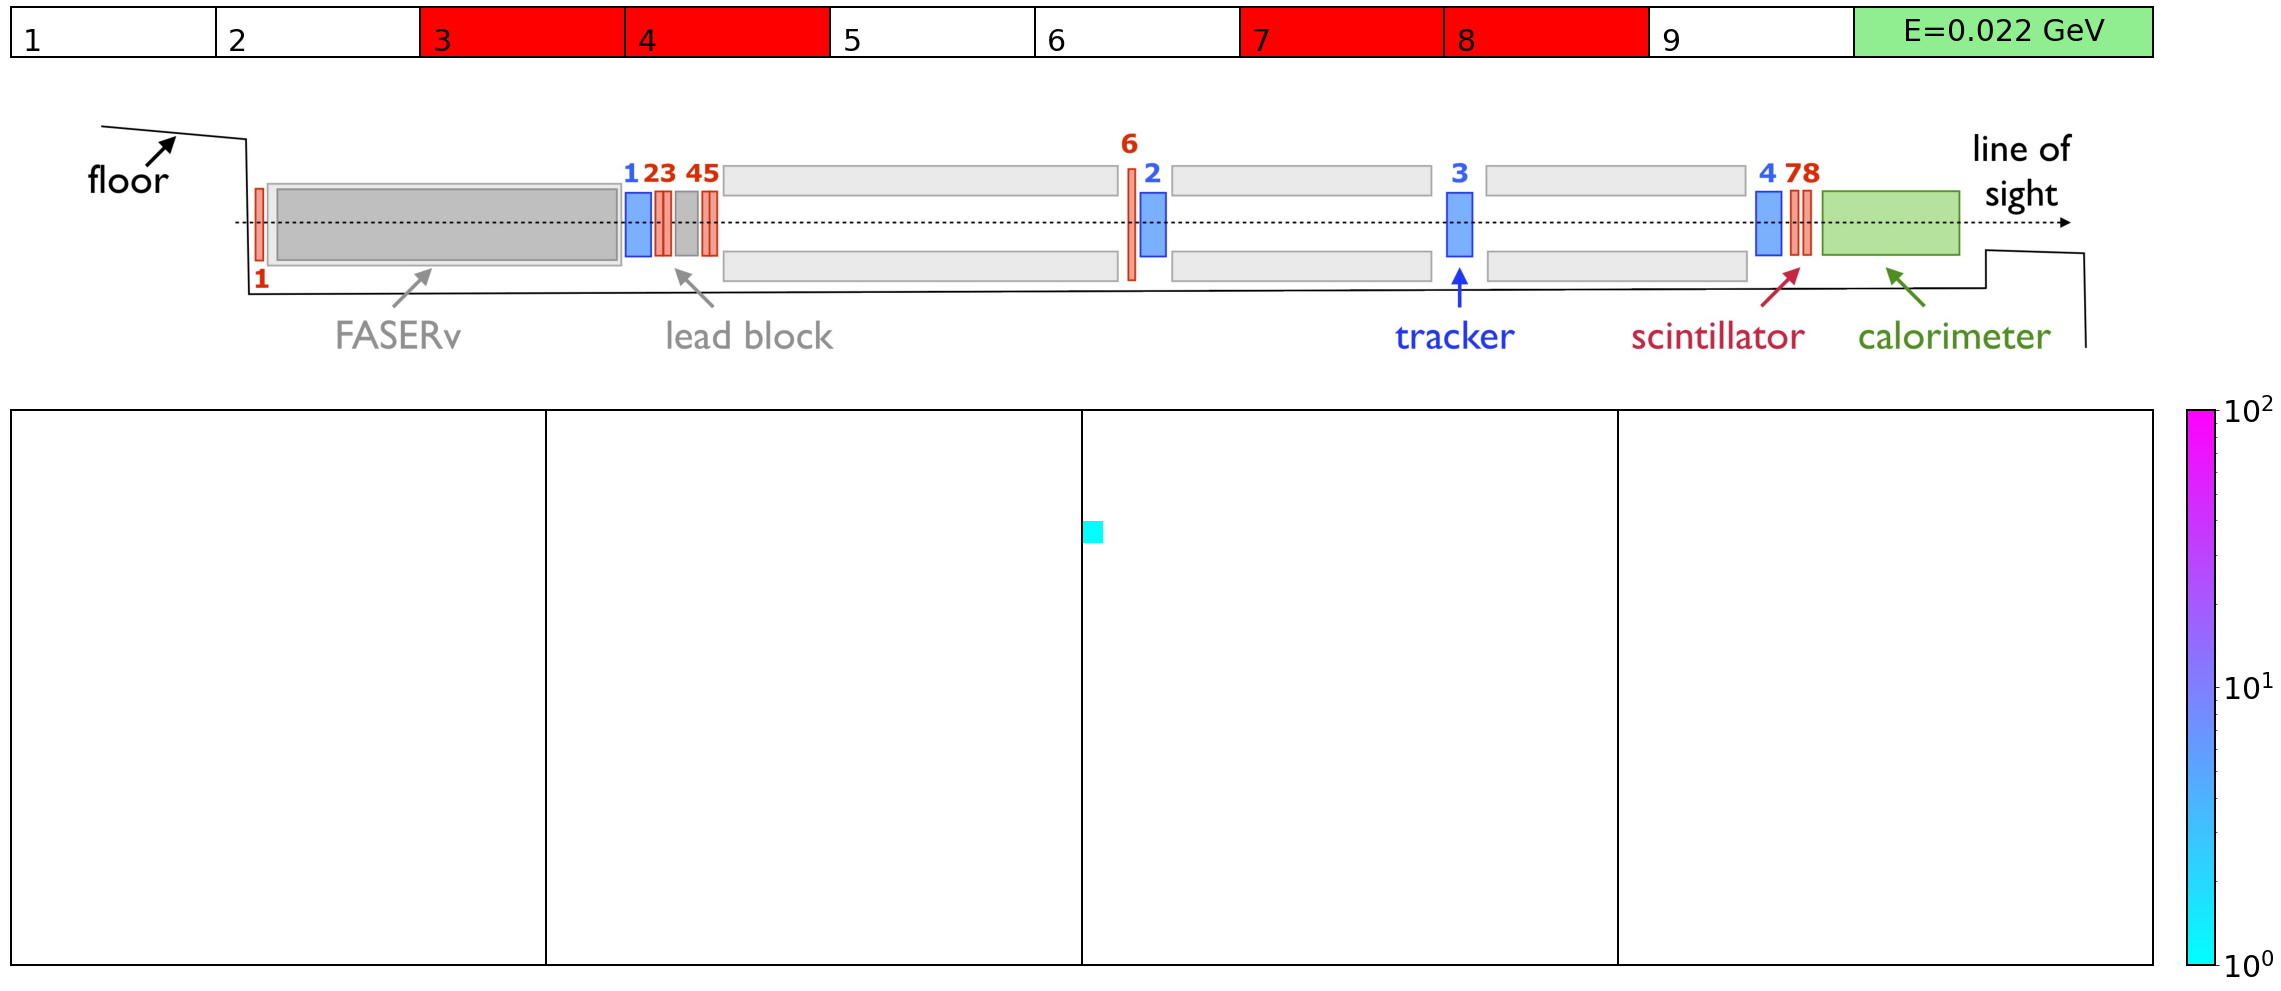

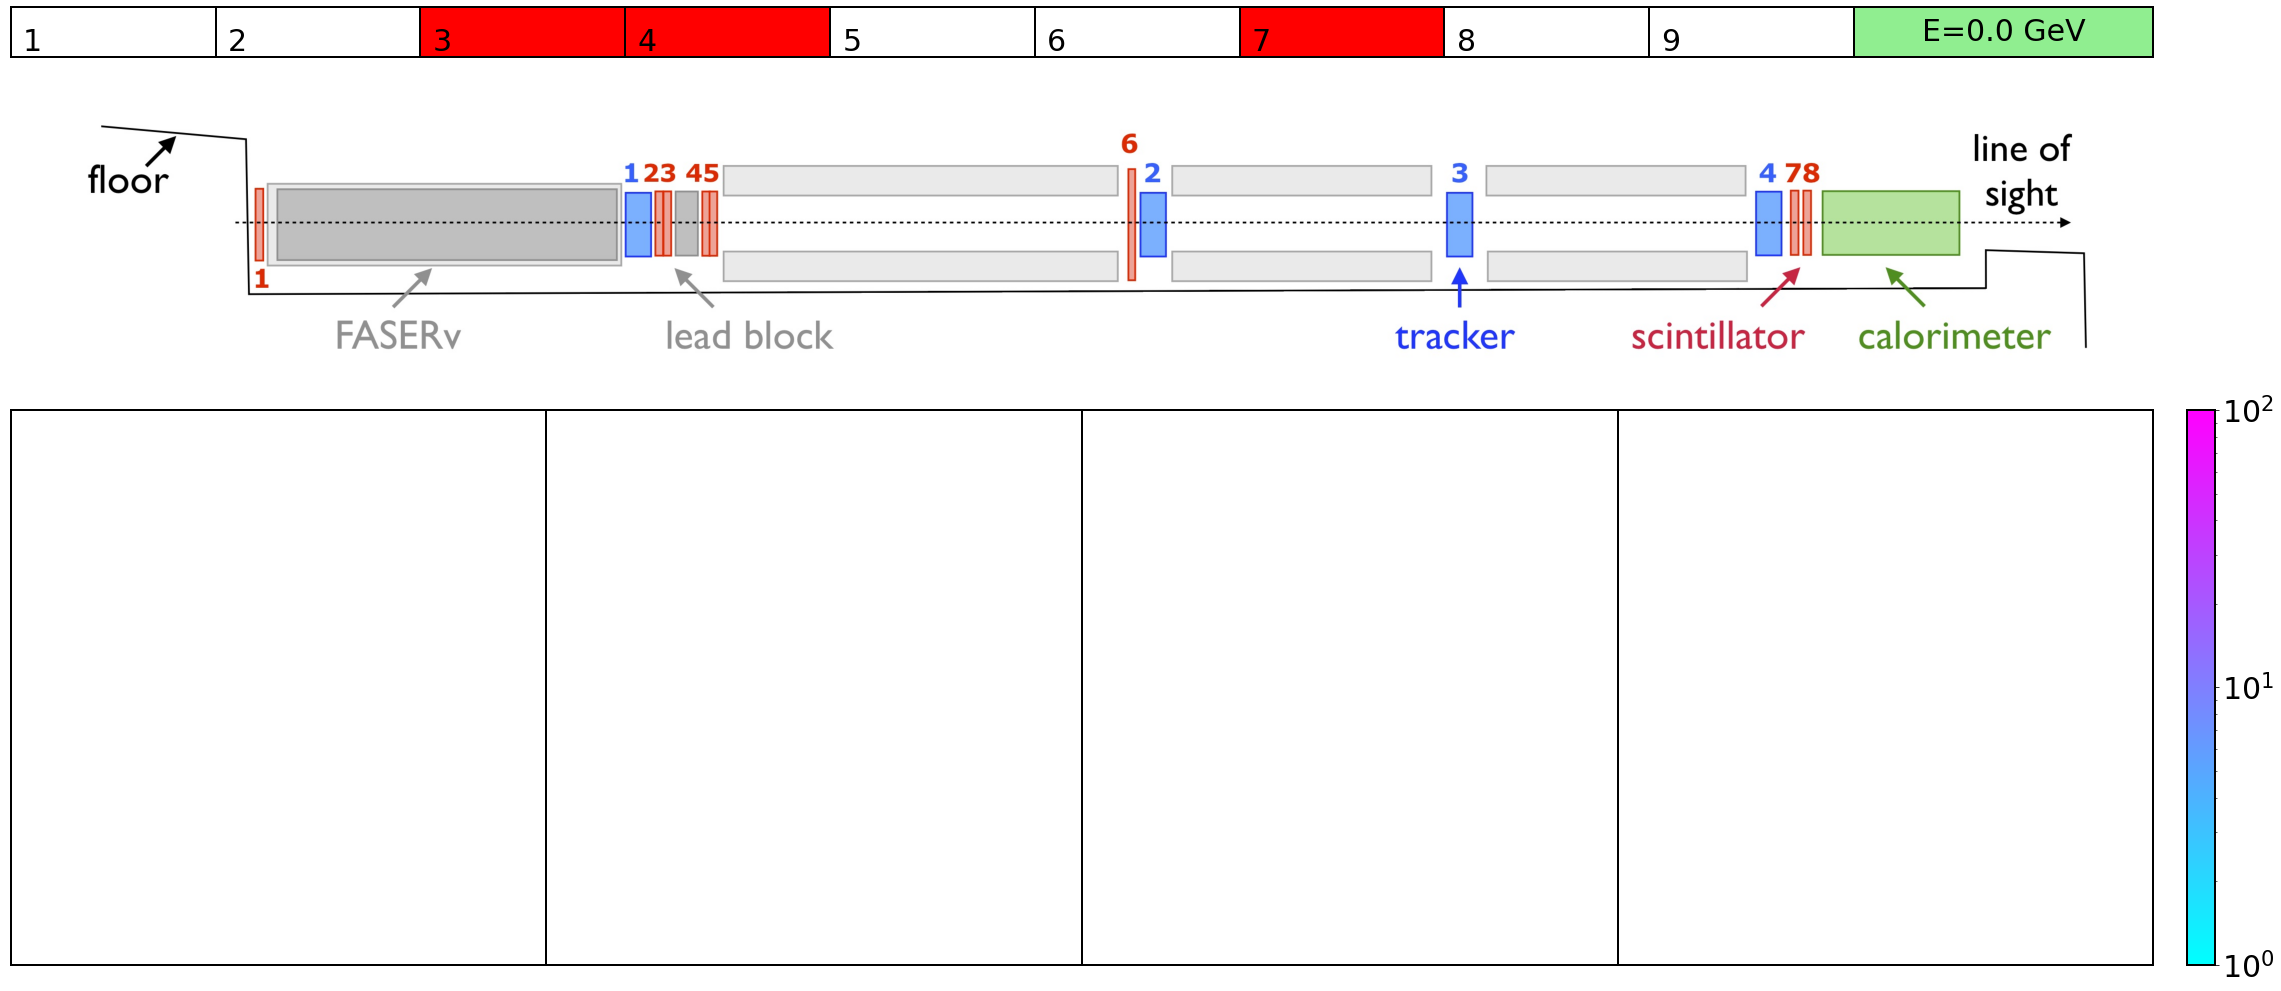

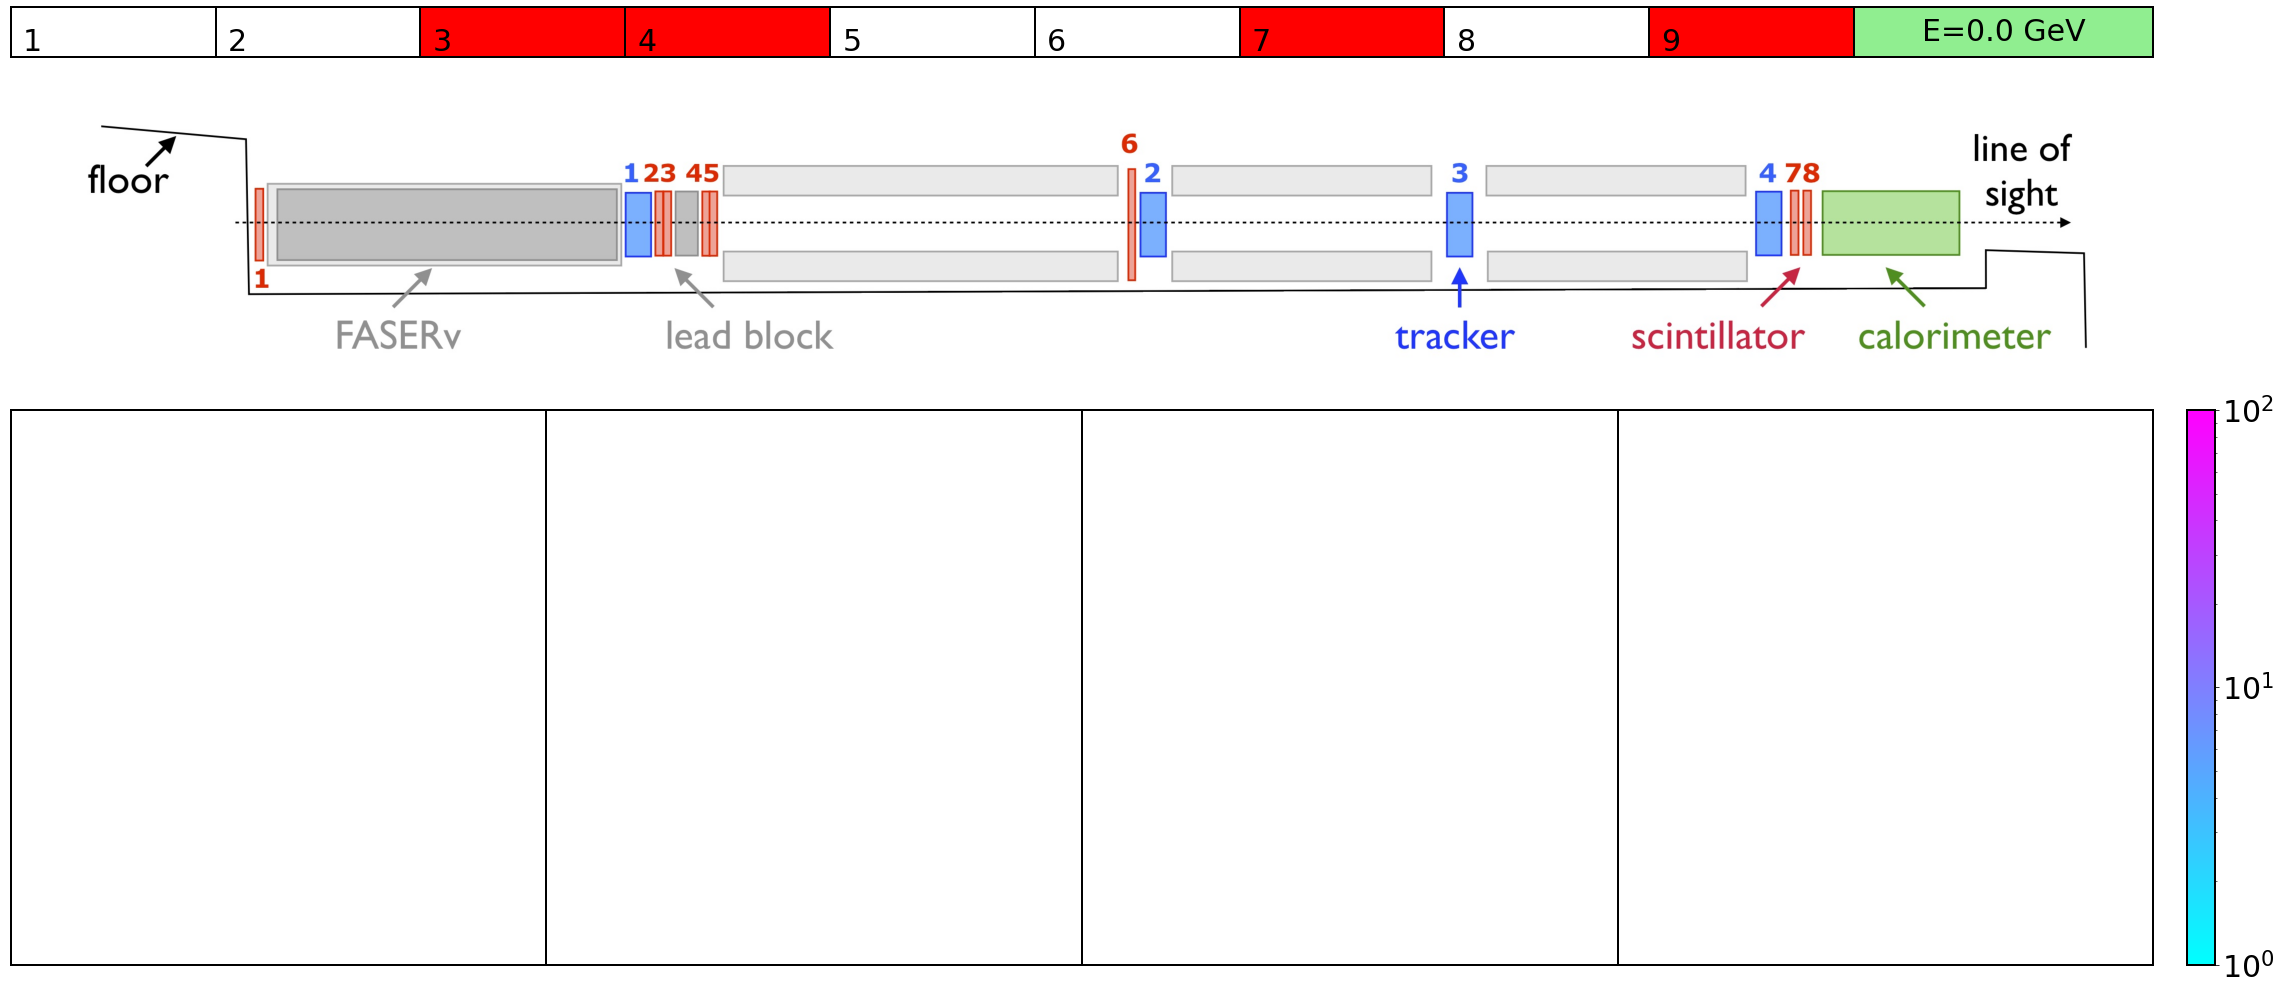

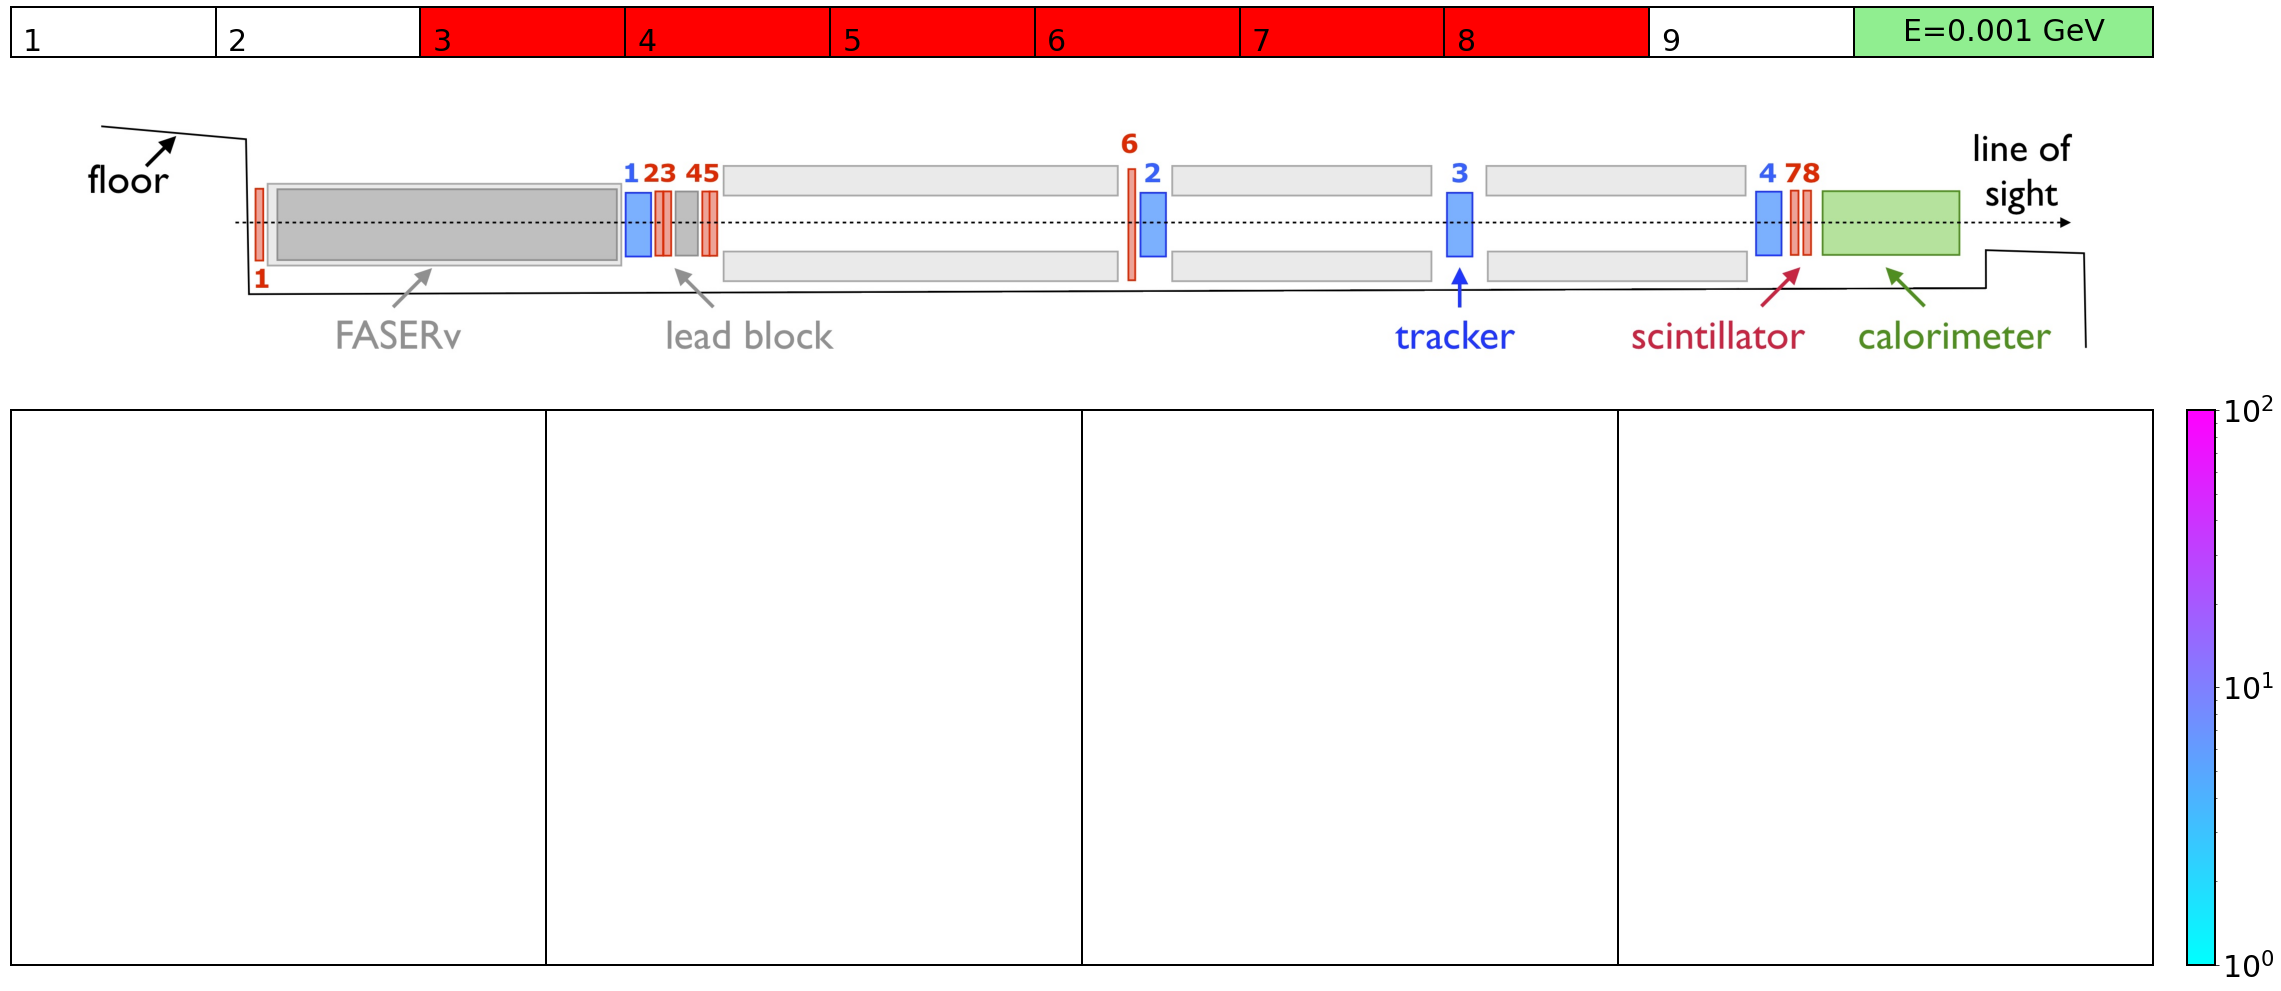

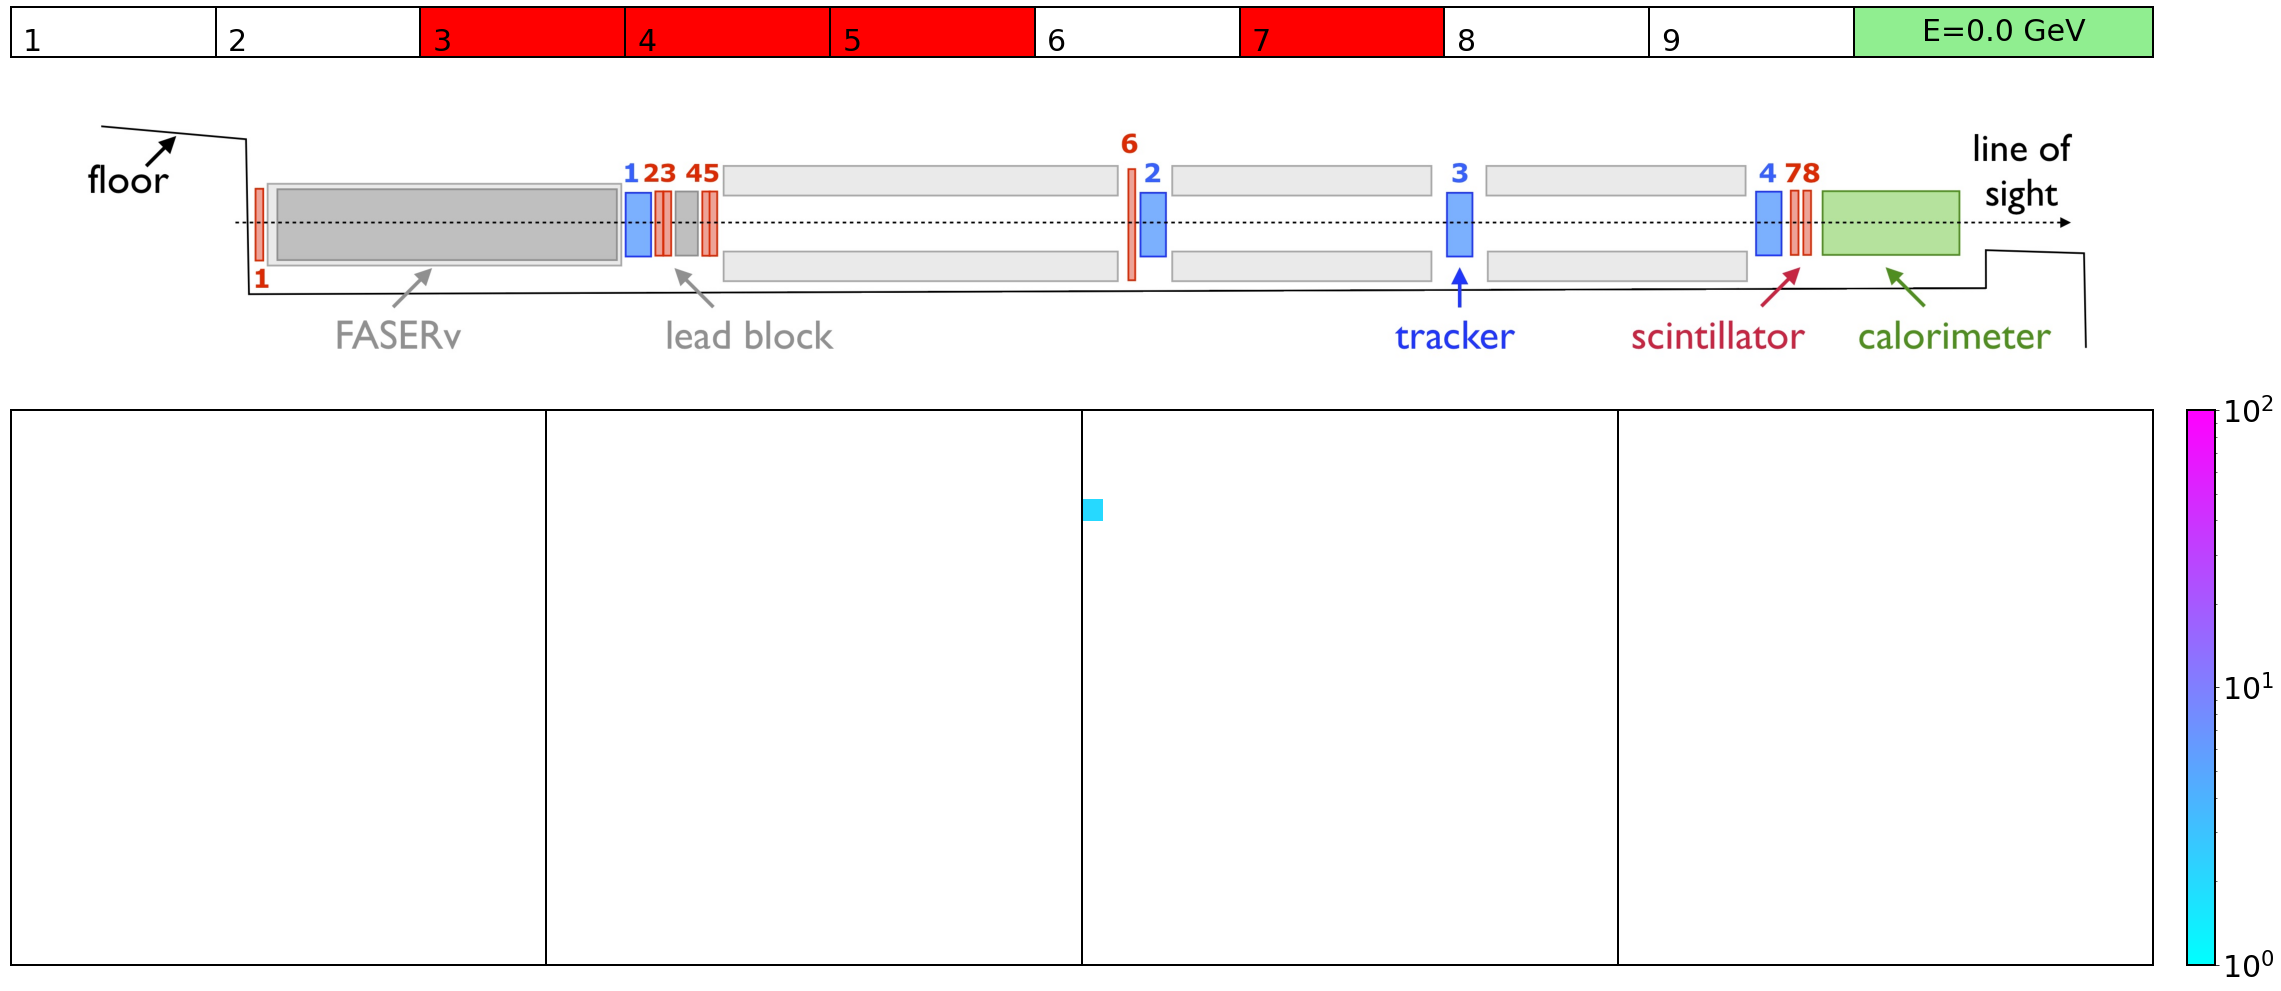

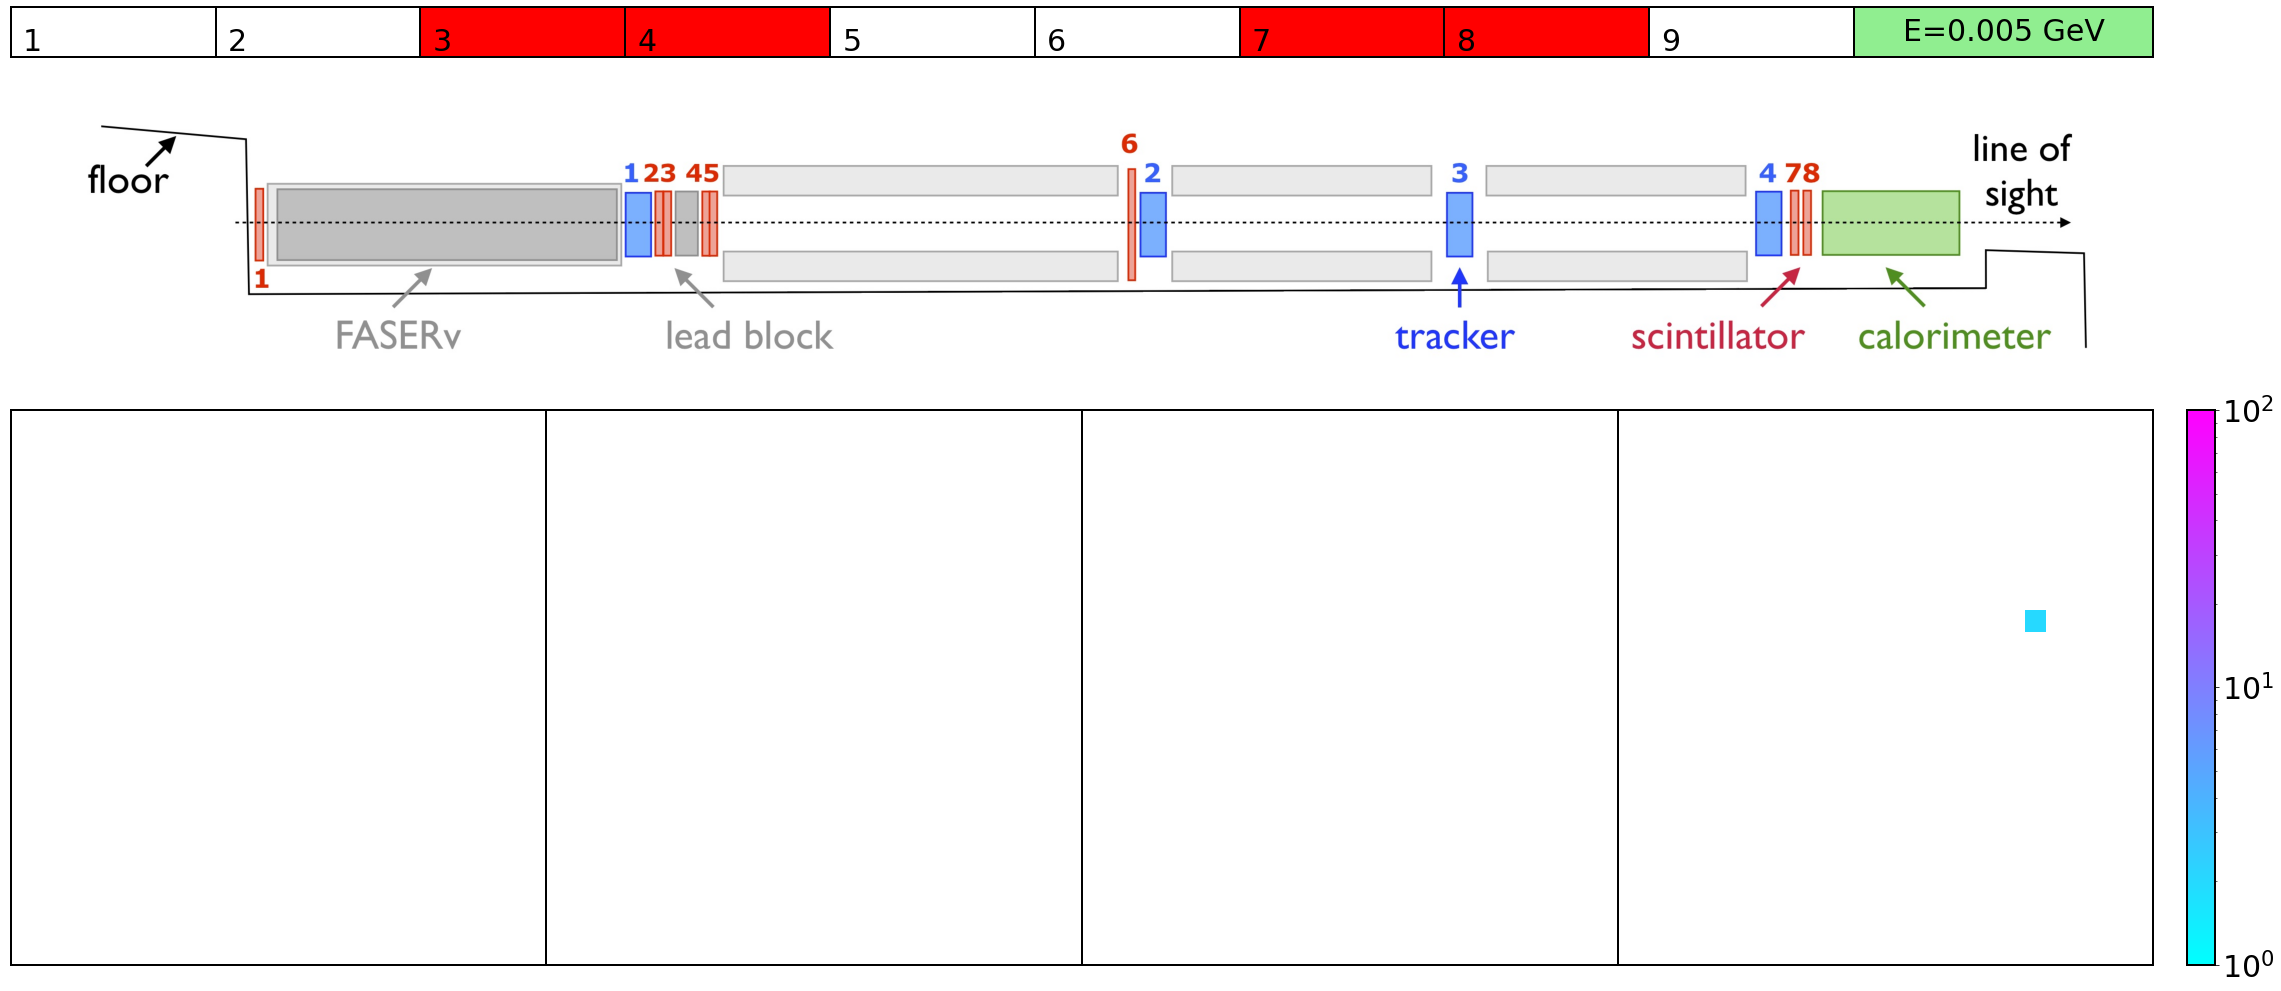

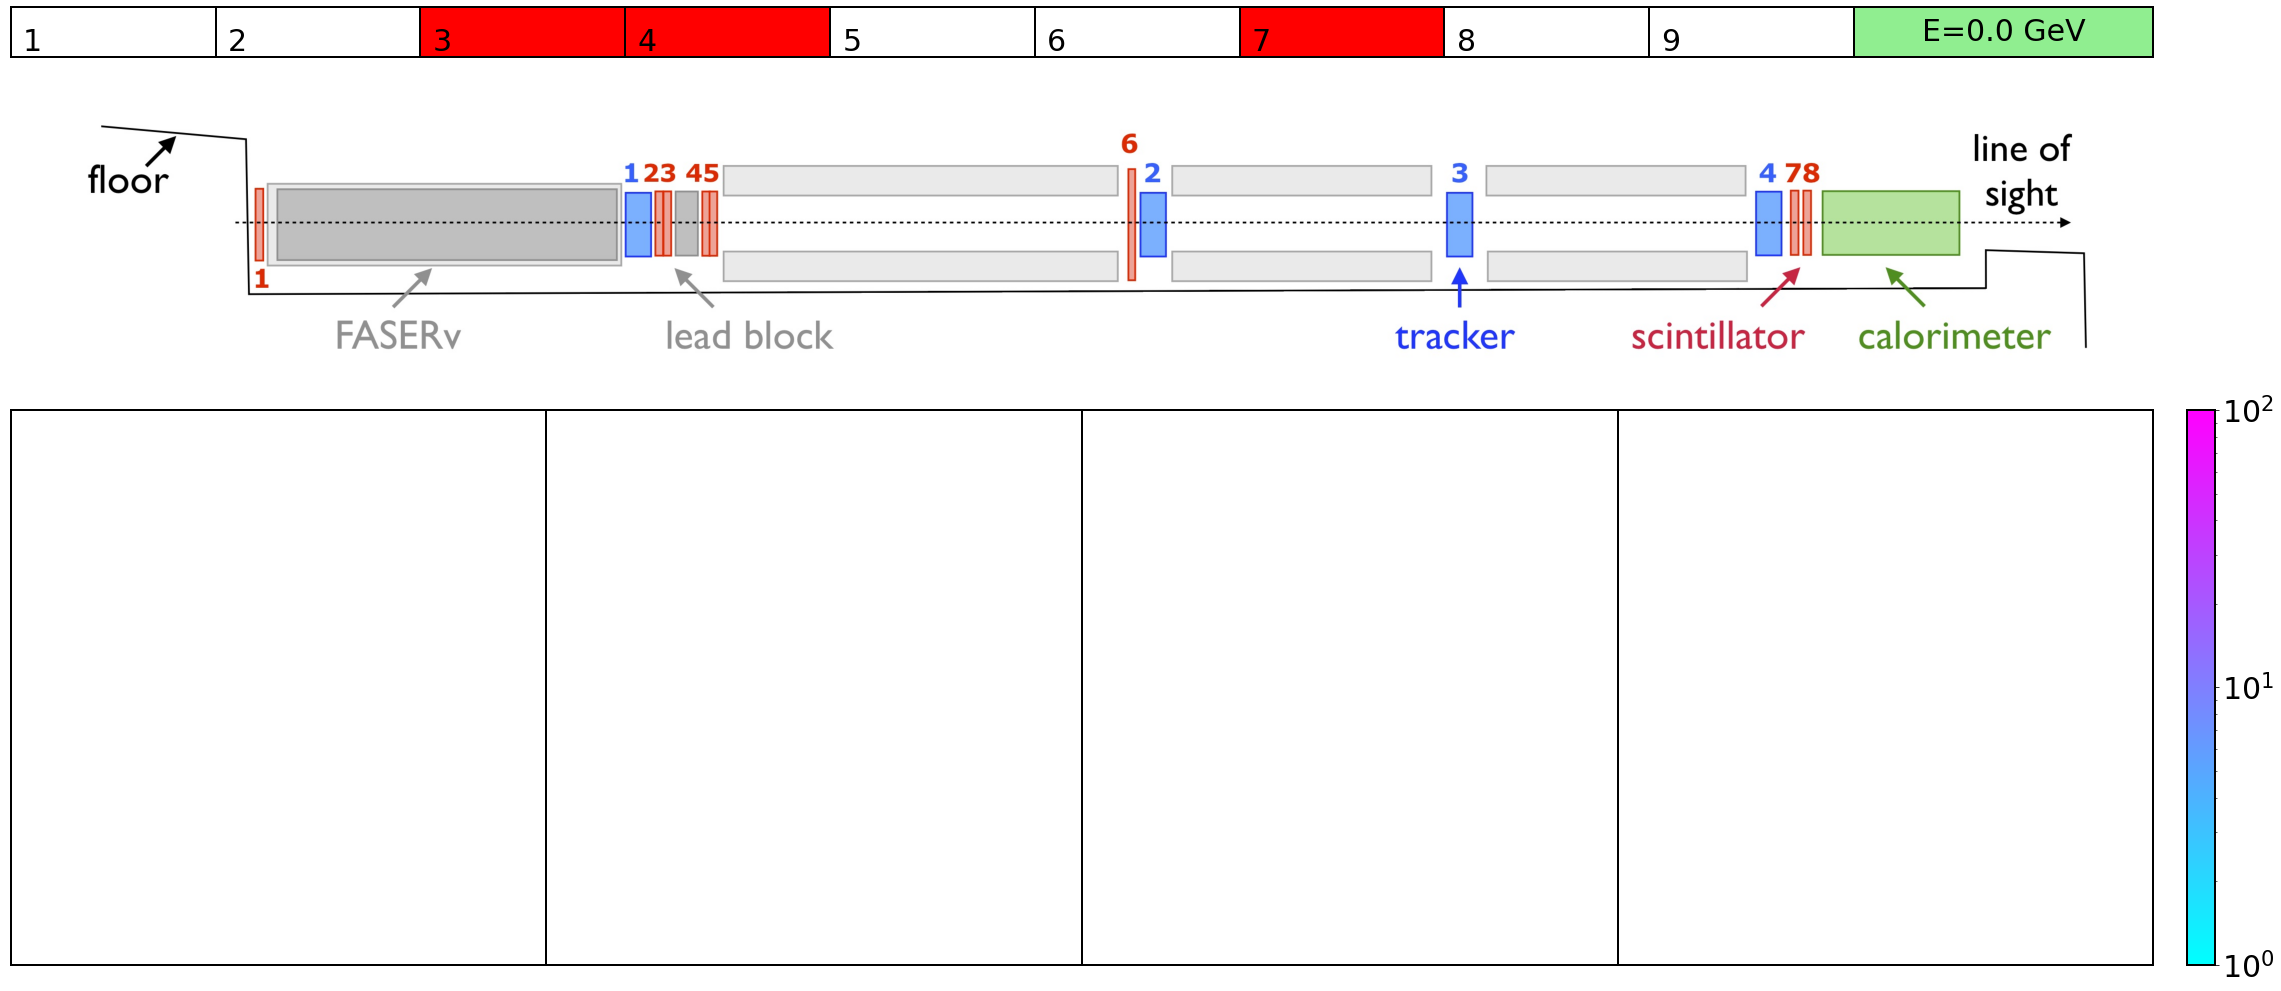

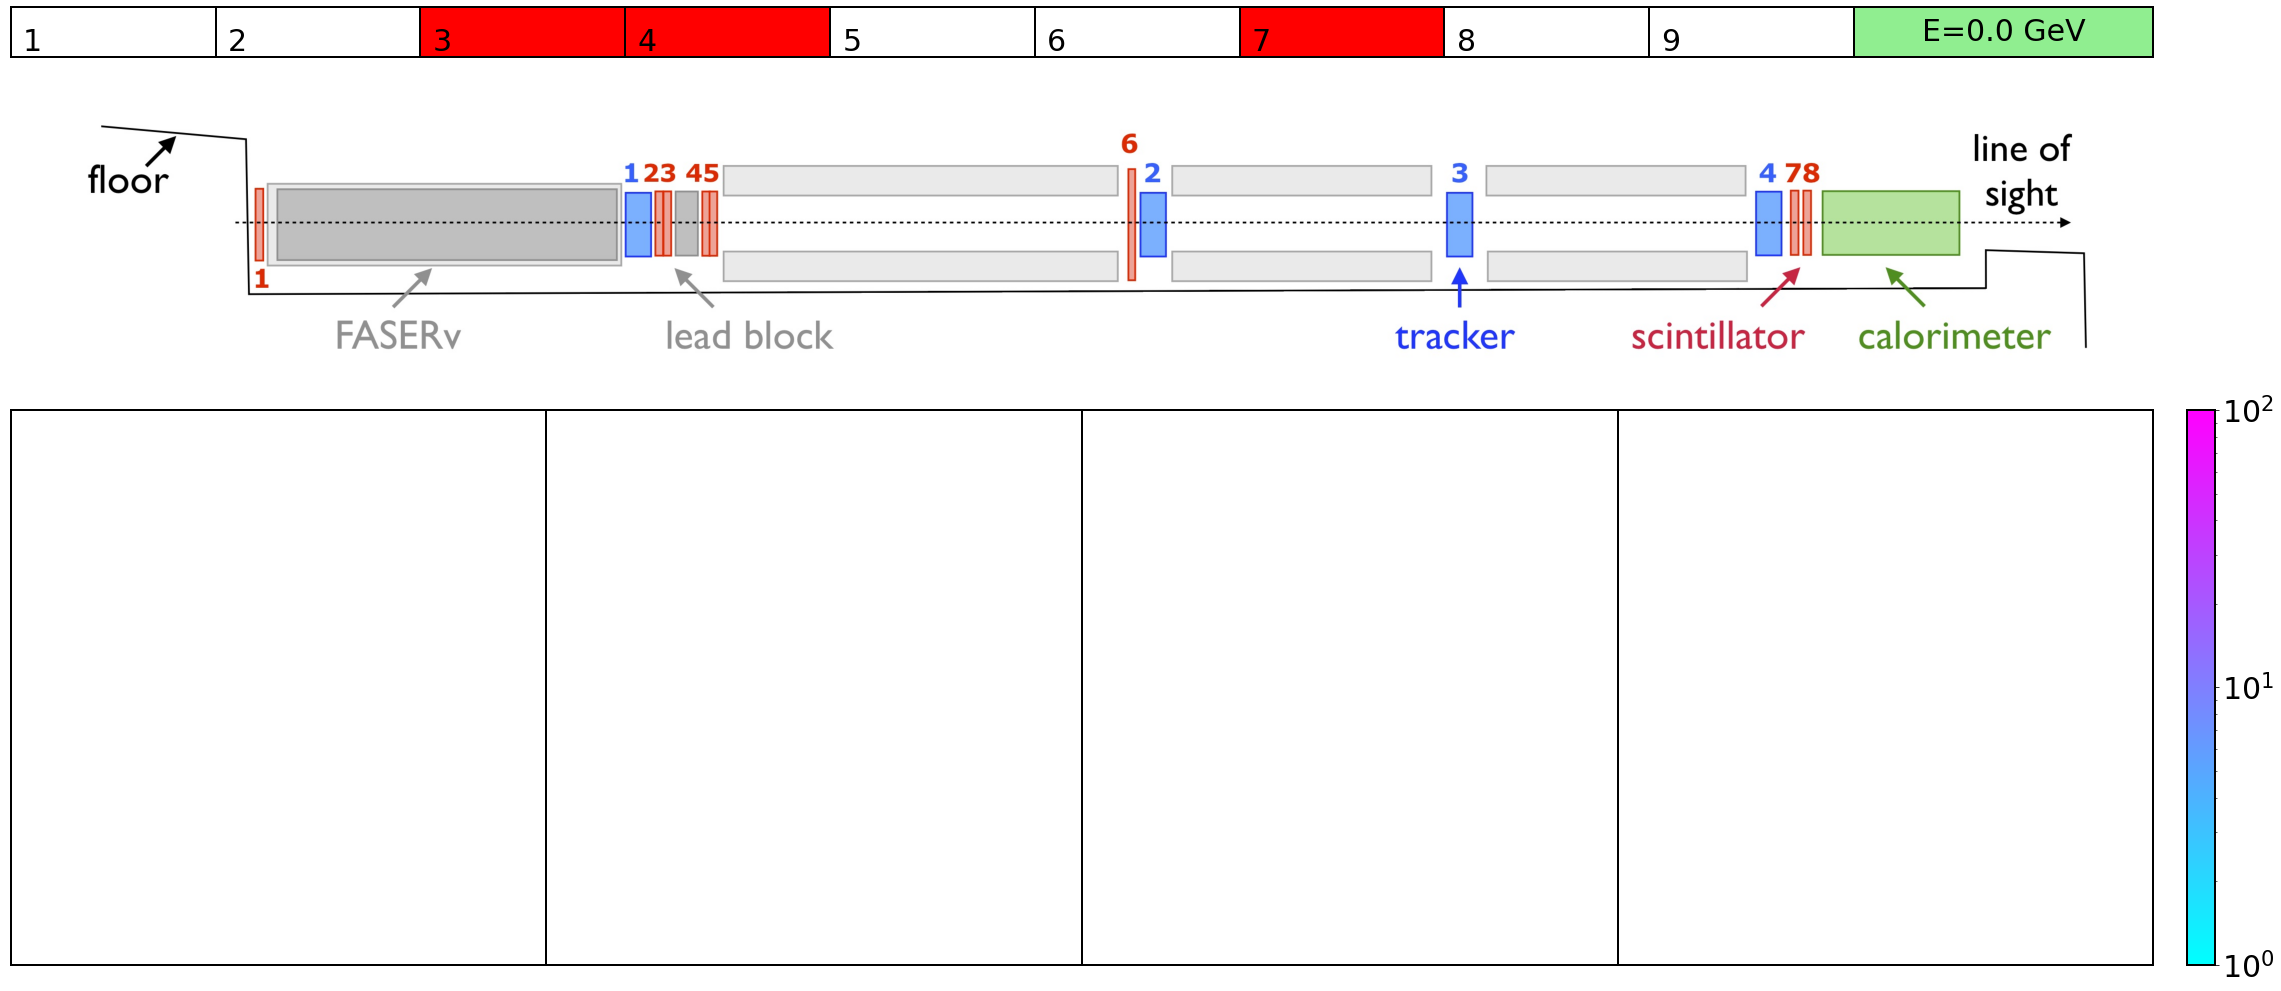

In [8]:
numevents = 0 
while numevents < 10:
    ievent = random.randrange(len(muon_data))
    numevents+=display_event(muon_data, ievent=ievent)